In [613]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [614]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.frame import DataFrame
from sklearn import metrics
import scipy

In [615]:
np.random.seed(0)

### write a class which can apply summary to lasso and ridge likes r

In [616]:
class ridge_summary:

    def __init__(self, clf, X, y):
        self.clf = clf
        self.X = X.values
        self.y = y.values.reshape(y.values.shape[0])
        self.columns = X.columns.tolist()

    def residuals(self, r_type='standardized'):

        X = self.X
        y = self.y
        clf = self.clf


        y_true = y.view(dtype='float')
      
        y_pred = clf.predict(X)
  
        y_pred = y_pred.reshape(y_true.shape[0],)
        y_true = y_true.reshape(y_true.shape[0],)
        
        resids = y_pred - y_true
        if r_type == 'standardized':
            resids = resids / np.std(resids)
        elif r_type == 'studentized':
            # Prepare a blank array to hold studentized residuals
            studentized_resids = np.zeros(y_true.shape[0], dtype='float')
            # Calcluate hat matrix of X values so you can get leverage scores
            hat_matrix = np.dot(
                np.dot(X, np.linalg.inv(np.dot(np.transpose(X), X))),
                np.transpose(X))
            # For each point, calculate studentized residuals w/ leave-one-out MSE
            for i in range(y_true.shape[0]):
                # Make a mask so you can calculate leave-one-out MSE
                mask = np.ones(y_true.shape[0], dtype='bool')
                mask[i] = 0
                loo_mse = np.average(resids[mask] ** 2, axis=0)  # Leave-one-out MSE
                # Calculate studentized residuals
                studentized_resids[i] = resids[i] / np.sqrt(
                    loo_mse * (1 - hat_matrix[i, i]))
            resids = studentized_resids
        return resids

    def sse(self):

        X = self.X
        y = self.y
        clf = self.clf

        y_hat = clf.predict(X)
        sse = np.sum((y_hat - y) ** 2)
        return sse

    def adj_r2_score(self):

        X = self.X
        y = self.y
        clf = self.clf

        n = X.shape[0]  # Number of observations
        p = X.shape[1]  # Number of features
        r_squared = metrics.r2_score(y, clf.predict(X))
        return 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))

    def coef_se(self):

        X = self.X
        y = self.y
        clf = self.clf

        n = X.shape[0]
        X1 = np.hstack((np.ones((n, 1)), np.matrix(X)))
        se_matrix = scipy.linalg.sqrtm(
            metrics.mean_squared_error(y, clf.predict(X)) *
            np.linalg.inv(X1.T * X1)
        )
        return np.diagonal(se_matrix)

    def coef_tval(self):
        X = self.X
        y = self.y
        clf = self.clf

        a = np.array(clf.intercept_ / self.coef_se()[0])
        b = np.array(clf.coef_ / self.coef_se()[1:])
        return np.append(a, b)

    def coef_pval(self):

        X = self.X
        y = self.y
        clf = self.clf

        n = X.shape[0]
        t = self.coef_tval()
        p = 2 * (1 - scipy.stats.t.cdf(abs(t), n - 1))
        return p

    def f_stat(self):

        X = self.X
        y = self.y
        clf = self.clf

        n = X.shape[0]
        p = X.shape[1]
        r_squared = metrics.r2_score(y, clf.predict(X))
        return (r_squared / p) / ((1 - r_squared) / (n - p - 1))

    def summary(self):

        X = self.X
        y = self.y
        clf = self.clf
        columns = self.columns

        ncols = X.shape[1]

        xlabels = columns

        coef_df = pd.DataFrame(
            index=['_intercept'] + list(xlabels),
            columns=['Estimate', 'Std. Error', 't value', 'p value']
        )
        try:
            coef_df['Estimate'] = np.concatenate(
                (np.round(np.array([clf.intercept_]), 6), np.round((clf.coef_), 6)))
        except:
            coef_df['Estimate'] = np.concatenate(
                (np.round(np.array([clf.intercept_]).reshape(1,), 6), np.round((clf.coef_).reshape(clf.coef_.shape[1],), 6)))
        coef_df['Std. Error'] = np.round(self.coef_se(), 6)
        coef_df['t value'] = np.round(self.coef_tval(), 4)
        coef_df['p value'] = np.round(self.coef_pval(), 6)
        # Create data frame to summarize residuals
        resids = self.residuals(r_type='raw')
        resids_df = pd.DataFrame({
            'Min': pd.Series(np.round(resids.min(), 4)),
            '1Q': pd.Series(np.round(np.percentile(resids, q=25), 4)),
            'Median': pd.Series(np.round(np.median(resids), 4)),
            '3Q': pd.Series(np.round(np.percentile(resids, q=75), 4)),
            'Max': pd.Series(np.round(resids.max(), 4)),
        }, columns=['Min', '1Q', 'Median', '3Q', 'Max'])
        # Output results
        print("Residuals:")
        print(resids_df.to_string(index=False))
        print('\n')
        print('Coefficients:')
        print(coef_df.to_string(index=True))
        print('---')
        print('R-squared:  {0:.5f},    Adjusted R-squared:  {1:.5f}'.format(
            metrics.r2_score(y, clf.predict(X)), self.adj_r2_score()))
        print('F-statistic: {0:.2f} on {1} features'.format(
            self.f_stat(), ncols))


## loading data

In [617]:
df = pd.read_csv('./abalone.csv')
df.head()

,Sex,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [618]:
df['Sex'].unique()

array(['M', 'F', 'I'], dtype=object)

# 1. one-hot encode

In [619]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

onehot_Sex = pd.DataFrame(OneHotEncoder().fit_transform(df[['Sex']]).toarray())
onehot_Sex.columns = ['Sex_F','Sex_I','Sex_M']

df = pd.concat([onehot_Sex,df],axis=1)
df = df.drop('Sex', axis=1)
df = df.drop('Sex_I', axis=1)

In [620]:
df.head()

,Sex_F,Sex_M,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Rings
0,0.0,1.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.0,1.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1.0,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.0,1.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.0,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# 2. Feature-Selection(Forward Search)

In [621]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [622]:
def forward_select(data,target):
    variate=set(data.columns) 
    variate.remove(target)  
    selected=[]
#     current_score,best_new_score = 0,0
    current_score,best_new_score = float('inf'),float('inf')
    aic_list = []
    model_list = []
    
    while variate:
        aic_with_variate=[]
        
        for candidate in variate:  
            formula="{}~{}".format(target,"+".join(selected+[candidate]))  
            aic = ols(formula=formula,data=data).fit().aic  
#             aic = ols(formula=formula,data=data).fit().rsquared
            aic_with_variate.append((aic,candidate))  
            
            model_list.append((formula))
            aic_list.append((round(aic, 2)))
            
        aic_with_variate.sort(reverse=True)  
        best_new_score,best_candidate = aic_with_variate.pop()  
        if current_score > best_new_score: 
            variate.remove(best_candidate)  
            selected.append(best_candidate)  
            current_score = best_new_score  
            print("aic is {},continuing!".format(current_score))  
        else:
            print("for selection over!")
            break
            
    formula="{}~{}".format(target,"+".join(selected))  #最终的模型式子
    print("final formula is {}".format(formula))
    model=ols(formula=formula,data=data).fit()
    
    data_frame = {"model" : model_list,"AIC" : aic_list}
    df_aic = DataFrame(data_frame)
    print(formula)
    return model,df_aic

In [623]:
model, df_aic = forward_select(data = df,target="Rings")

aic is 19545.516772497096,continuing!
aic is 18955.711532283727,continuing!
aic is 18725.7557629171,continuing!
aic is 18620.17660109886,continuing!
aic is 18570.397786719506,continuing!
aic is 18514.65787468743,continuing!
aic is 18489.331049644938,continuing!
aic is 18426.303530456193,continuing!
for selection over!
final formula is Rings~Shell_Weight+Shucked_Weight+Diameter+Whole_Weight+Viscera_Weight+Height+Sex_M+Sex_F
Rings~Shell_Weight+Shucked_Weight+Diameter+Whole_Weight+Viscera_Weight+Height+Sex_M+Sex_F


final formula is 
>Rings~Shell_Weight+Shucked_Weight+Diameter+Sex_I+Whole_Weight+Viscera_Weight+Height

# 3. Split Data to train-set and test-set

In [624]:
from sklearn.model_selection import train_test_split

In [625]:
df_modelsec = df[['Shell_Weight','Shucked_Weight','Whole_Weight','Viscera_Weight','Height','Diameter',
                  'Sex_F','Sex_M','Rings']]

## Split Data - first time

In [626]:
data_test = df_modelsec.sample(n=int(df_modelsec.shape[0]*0.2))
data_test.shape

(835, 9)

In [627]:
data_train_index = []
for i in df.index:
    if i not in data_test.index:
        data_train_index.append(i)

In [628]:
data_train = df_modelsec.iloc[data_train_index,]

In [629]:
data_train.head()
data_train.shape

,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings
0,0.150,0.2245,0.5140,0.1010,0.095,0.365,0.0,1.0,15
2,0.210,0.2565,0.6770,0.1415,0.135,0.420,1.0,0.0,9
3,0.155,0.2155,0.5160,0.1140,0.125,0.365,0.0,1.0,10
5,0.120,0.1410,0.3515,0.0775,0.095,0.300,0.0,0.0,8
6,0.330,0.2370,0.7775,0.1415,0.150,0.415,1.0,0.0,20


(3342, 9)

## Split Data - second time

In [630]:
x_train, x_test, y_train, y_test = train_test_split(data_train.iloc[:,:-1],data_train.iloc[:,[-1]], test_size=0.2)

In [631]:
df_train = pd.concat([x_train,y_train],axis=1)
df_train.head()
df_train.shape

,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings
649,0.1400,0.1695,0.4470,0.0810,0.125,0.360,1.0,0.0,9
2190,0.3150,0.3215,0.9270,0.1985,0.165,0.470,0.0,1.0,11
1128,0.2450,0.3360,0.6405,0.1765,0.155,0.440,1.0,0.0,8
3518,0.4535,0.8985,1.3480,0.4435,0.195,0.570,0.0,1.0,11
2991,0.2760,0.5305,1.0835,0.2310,0.150,0.485,0.0,1.0,8


(2673, 9)

# 4. Verificate assumptions of Linear Regression

In [632]:
lm_reg = ols('Rings ~ Shell_Weight + Shucked_Weight + Whole_Weight + Viscera_Weight + Height + Diameter + Sex_F + Sex_M',
             data = df_train).fit()


## 4.1 normality test

### - histogram

<Figure size 640x480 with 0 Axes>

<AxesSubplot:ylabel='Density'>

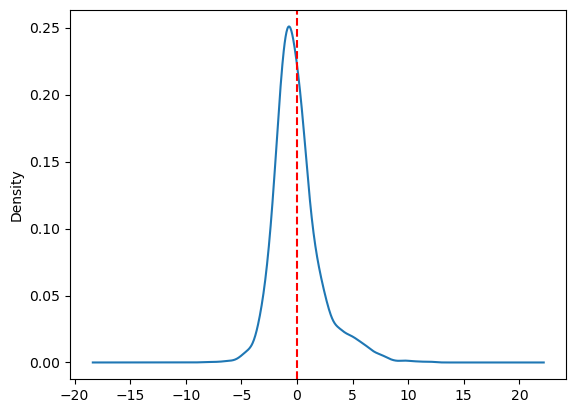

In [633]:
plt.figure()
lm_reg.resid.plot.density()
plt.axvline(0, c='r',linestyle = 'dashed')
plt.show()

### - **Q-Q plot**

In [634]:
residual_reg = lm_reg.resid

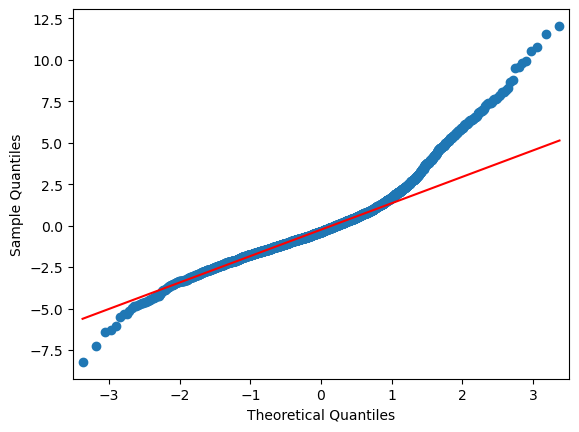

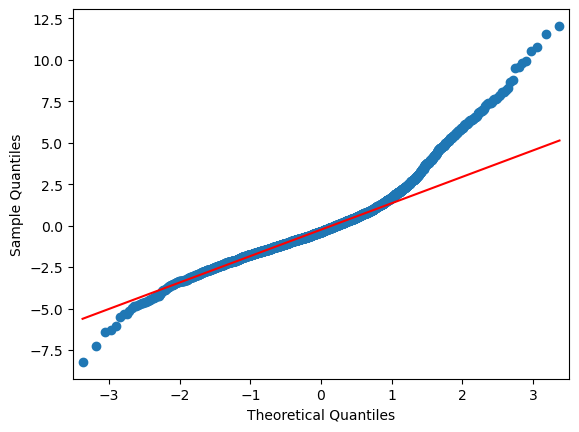

In [635]:
pq = sm.ProbPlot(lm_reg.resid)
pq.qqplot(line='q')

### -**Shapiro-Wilk test**

In [636]:
import scipy.stats as stats
stats.shapiro(residual_reg)

ShapiroResult(statistic=0.9229985475540161, pvalue=5.802120155541955e-35)

In [637]:
stats.shapiro(residual_reg)[1] < 0.05

True

> It can be seen that the P-value is very small, much less than 0.05, so the null hypothesis is rejected, indicating that the residuals do not obey the normal distribution.

## 4.2 independence test - Durbin-Watson Test

- Null hypothesis ($H_0$): Residuals from the regression are not autocorrelated (autocorrelation coefficient, ρ = 0)
- Alternative hypothesis ($H_1$): Residuals froms the regression are autocorrelated (autocorrelation coefficient, ρ > 0)

In [638]:
from statsmodels.stats.stattools import durbin_watson as dwtest
dwtest(resids=np.array(residual_reg))

2.075752409579219

> As the Durbin-Watson statistics is close to 2, we fail to reject the null hypothesis().
  **Hence, we conclude that the residuals are not autocorrelated.**

## 4.3  Constance test of variance

### - plot: independent variable ～ residual

In [639]:
lm_reg_predict = lm_reg.predict(x_train)

Text(0.5, 0, 'predictor')

Text(0, 0.5, 'residual')

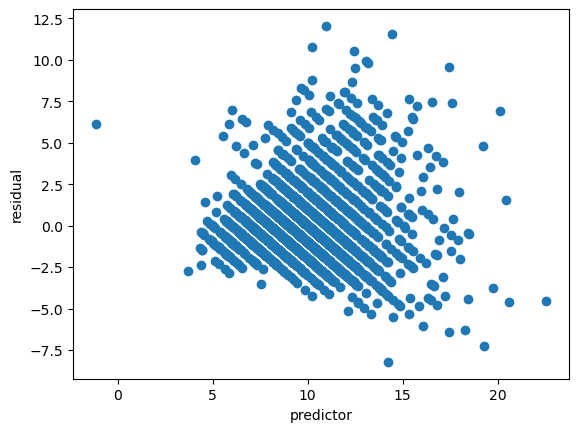

In [640]:
plt.scatter(lm_reg_predict, residual_reg)

plt.xlabel('predictor')
plt.ylabel('residual')
plt.show()

> The variance of the residual (that is, the fluctuation of the observation point relative to the red dotted line) does not fluctuate greatly with the change of the independent variable, indicating that the variance of the residual is continuous

### # delete bp test

In [641]:
# delete bp test
bp = sm.stats.diagnostic.het_breuschpagan(residual_reg,lm_reg.model.exog)
bp

(270.9402735100876,
 6.210106775017199e-54,
 37.56072760551237,
 6.289910055941536e-57)

### Summary of residual analysis

|  Residual TEST ITEM   | method/index  | value  | conclusion 
|  ----  | ----  | ----  | ----  |
| normality test | histogram |   | Normal  |
|   | Q-Q plot | heavy-tailed distributions  |  Abnormal | 
|   | Shapiro-Wilk test | p-value < 0.05  | Abnormal  | 
|   |  |   |   | 
| independence test  | Durbin-Watson Test  |statistics is close to 2   | independent  | 
|   |  |   |   | 
|  homogeneity test of variance | plot: independent variable ～ residual |  |  homogeneous | 


## 4.4 Deal with Normality

### - BOX-COX

In [642]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    
    skewed_feats = df[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
    
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))
    
    return df

- applying box-cox to data

In [643]:
df_train_box_cox = pd.concat([fixing_skewness(df_train.iloc[:,:-4]),df_train.iloc[:,-4:]],axis=1)

In [644]:
df_train_box_cox.head()

,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings
649,0.122752,0.149257,0.382033,0.073244,0.125,0.360,1.0,0.0,9
2190,0.239324,0.256131,0.696182,0.157272,0.165,0.470,0.0,1.0,11
1128,0.196641,0.265290,0.517679,0.143185,0.155,0.440,1.0,0.0,8
3518,0.311621,0.529559,0.922490,0.277854,0.195,0.570,0.0,1.0,11
2991,0.216123,0.374346,0.784653,0.176896,0.150,0.485,0.0,1.0,8


In [645]:
lm_reg_coxbox = lm_reg = ols('Rings ~ Shell_Weight + Shucked_Weight + Whole_Weight + Viscera_Weight + Height + Diameter + Sex_F + Sex_M',
                 data = df_train_box_cox).fit()


In [646]:
residual_box = lm_reg_coxbox.resid

In [647]:
import scipy.stats as stats
stats.shapiro(residual_box)[1] < 0.05

True

In [648]:
stats.shapiro(residual_box)[1] > stats.shapiro(residual_reg)[1]

True

### - log/sqrt

- log

In [649]:
def log_todata(df):

    
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    for feat in numeric_feats:
        df[feat] = df[feat].apply(np.log1p)
    
    return df

In [650]:
df_train_log = pd.concat([log_todata(df_train.iloc[:,:-2]),df_train.iloc[:,-2:]],axis=1)

In [651]:
df_train_log.head()

,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings
649,0.131028,0.156576,0.369492,0.077887,0.117783,0.307485,0.693147,0.0,9
2190,0.273837,0.278767,0.655964,0.181071,0.152721,0.385262,0.000000,1.0,11
1128,0.219136,0.289680,0.495001,0.162544,0.144100,0.364643,0.693147,0.0,8
3518,0.373974,0.641064,0.853564,0.367071,0.178146,0.451076,0.000000,1.0,11
2991,0.243730,0.425594,0.734049,0.207827,0.139762,0.395415,0.000000,1.0,8


In [652]:
lm_reg_log = ols('Rings ~ Shell_Weight + Shucked_Weight + Whole_Weight + Viscera_Weight + Height + Diameter + Sex_F + Sex_M',
                 data = df_train_log).fit()


In [653]:
residual_log = lm_reg_coxbox.resid

In [654]:
import scipy.stats as stats
stats.shapiro(residual_log)[1] < 0.05

True

- sqrt

In [655]:
def sqrt_todata(df):

    
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    for feat in numeric_feats:
        df[feat] = df[feat].apply(np.sqrt)
    
    return df

In [656]:
df_train_sqrt = pd.concat([sqrt_todata(df_train.iloc[:,:-2]),df_train.iloc[:,-2:]],axis=1)

In [657]:
df_train_sqrt.head()

,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings
649,0.374166,0.411704,0.668581,0.284605,0.353553,0.600000,1.0,0.0,9
2190,0.561249,0.567010,0.962808,0.445533,0.406202,0.685565,0.0,1.0,11
1128,0.494975,0.579655,0.800312,0.420119,0.393700,0.663325,1.0,0.0,8
3518,0.673424,0.947892,1.161034,0.665958,0.441588,0.754983,0.0,1.0,11
2991,0.525357,0.728354,1.040913,0.480625,0.387298,0.696419,0.0,1.0,8


In [658]:
lm_reg_sqrt =  ols('Rings ~ Shell_Weight + Shucked_Weight + Whole_Weight + Viscera_Weight + Height + Diameter + Sex_F + Sex_M',
                 data = df_train_sqrt).fit()


In [659]:
residual_sqrt = lm_reg_sqrt.resid

In [660]:
import scipy.stats as stats
stats.shapiro(residual_sqrt)[1] < 0.05

True

# 5.  multicollinearity

## 5.1 heatmap

(<Figure size 800x400 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

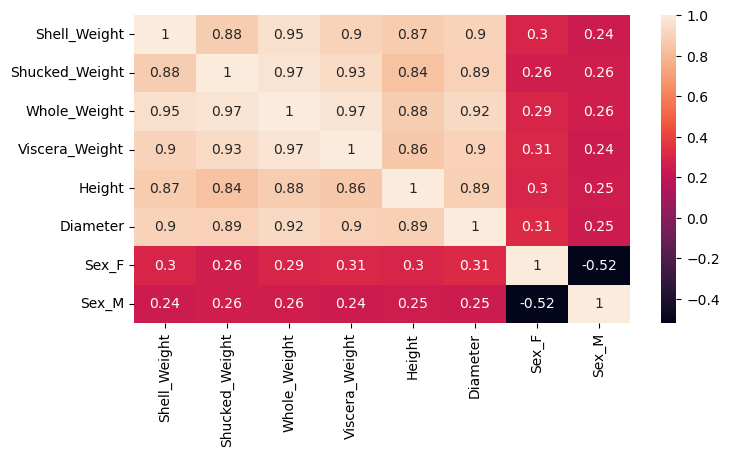

In [768]:
corrmat = df_train.iloc[:,:-1].corr()
plt.subplots(figsize=(8,4))
sns.heatmap(corrmat,annot=True)
plt.show()

- **exclude gender's thermodynamic diagram**

(<Figure size 500x500 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

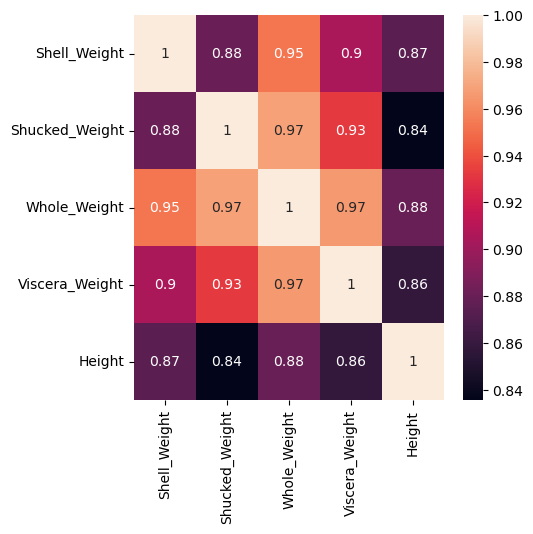

In [662]:
corrmat = df_train.iloc[:,:-4].corr()
plt.subplots(figsize=(5,5))
sns.heatmap(corrmat,annot=True)
plt.show()

### 5.2 Calculate VIF

In [663]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [664]:
y, X = dmatrices('Rings ~ Shell_Weight + Shucked_Weight + Whole_Weight + Viscera_Weight + Height + Diameter + Sex_F + Sex_M',
                 data = df_train, return_type='dataframe')


In [665]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,VIF
0,53.935642
1,19.288232
2,26.481374
3,97.581766
4,16.613612
5,5.787729
6,8.817886
7,1.979706
8,1.883896


## 5.3  solution 1: Remove some features

#### we can easily find that
- the correlations between (Height, Diameter), (Whole_weight, Shucked_Weight , Viscera_Weight, Shell_Weight) are large
- we can just retain 1 feature from each cluster

In [666]:
y, X = dmatrices('Rings ~ Sex_F + Sex_M + Height + Whole_Weight',
                 data = df_train, return_type='dataframe')

In [667]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,VIF
0,22.792495
1,1.918519
2,1.866697
3,4.529150
4,4.569976


In [668]:
#the removed ols
lm_reg_remove = ols('Rings ~ Sex_F  +  Height + Whole_Weight',
                 data = df_train).fit()

In [669]:
# the original
lm_reg.rsquared

#the removed ols
lm_reg_remove.rsquared

0.5531107492564397

0.34831463050432054

## 5.4 solution 2: PCA

In [670]:
from sklearn.decomposition import PCA

In [671]:
pca = PCA(n_components='mle') 
pca = pca.fit(df_train.iloc[:,:-4]) 
X_dr = pca.transform(df_train.iloc[:,:-4])

In [672]:
X_dr.shape

(2673, 4)

In [673]:
weight_pca = pd.DataFrame(X_dr).rename(columns={0:'pca_weight_1',1:'pca_weight_2',2:'pca_weight_3',
                                               3:'pca_weight_4'})

In [674]:
df_pca = pd.concat([weight_pca,df_train],axis=1)

In [675]:
df_pca.head()

,pca_weight_1,pca_weight_2,pca_weight_3,pca_weight_4,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings
0,-0.459247,0.020415,-0.006767,-0.011933,0.150,0.2245,0.514,0.1010,0.095,0.365,0.0,1.0,15.0
1,0.082792,0.094622,0.001617,0.000127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.182350,-0.007265,-0.027339,0.078599,0.210,0.2565,0.677,0.1415,0.135,0.420,1.0,0.0,9.0
3,0.751309,-0.187863,-0.048973,0.239064,0.155,0.2155,0.516,0.1140,0.125,0.365,0.0,1.0,10.0
4,0.295275,-0.064960,-0.008627,-0.000104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [676]:
lm_reg_pca = ols('Rings ~ pca_weight_1 + pca_weight_2 + pca_weight_3 +  pca_weight_4',
                 data = df_pca).fit()

In [677]:
y, X = dmatrices('Rings ~ pca_weight_1 + pca_weight_2 + pca_weight_3 +  pca_weight_4',
                 data = df_pca, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,VIF
0,1.000344
1,1.001488
2,1.002764
3,1.003013
4,1.002403


In [678]:
# model after PCA
lm_reg_pca.rsquared

# original model
lm_reg.rsquared

0.002426070794110724

0.5531107492564397

## 5.5 Solution3: Ridge/Lasso

In [679]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

#### - Lasso

In [680]:
las = Lasso(alpha = 0.01)

las.fit(x_train, y_train)
las.coef_

Lasso(alpha=0.01)

array([ 12.43976424, -13.0764429 ,   4.32340234,  -0.        ,
         0.        ,   5.67999596,   0.84396913,   0.88057425])

In [681]:
las_predict = las.predict(x_test)

In [682]:
# lasso
print("MSE:",metrics.mean_squared_error(y_test, las_predict))
print("R_2:",r2_score(y_test, las_predict))

MSE: 5.19872189496786
R_2: 0.5096619668789146


In [683]:
# the original

lr = LinearRegression().fit(x_train, y_train)
lr.fit(x_train, y_train)

lr_predict = lr.predict(x_test)

print("MSE:",metrics.mean_squared_error(y_test, lr_predict))
print("R_2:",r2_score(y_test, lr_predict))

LinearRegression()

MSE: 5.064231909940765
R_2: 0.5223469221554227


#### - ridge

In [684]:
rr = Ridge(alpha=0.01) 
rr.fit(x_train, y_train)

Ridge(alpha=0.01)

In [685]:
rr.coef_
rr.intercept_

array([[  8.04780282, -19.39245154,   9.04280029, -11.13388794,
         14.25690699,   9.53735124,   0.76837306,   0.84726946]])

array([3.04860215])

In [686]:
rr_predict = rr.predict(x_test)

In [687]:
print("MSE:",metrics.mean_squared_error(y_test, rr_predict))
print("R_2:",r2_score(y_test, rr_predict))

MSE: 5.058687851531062
R_2: 0.5228698319688431


---

# 6. Unusual Observations

## 6.1 Leverage Point

### - hatvalue

In [688]:
influence = lm_reg.get_influence()

In [689]:
from statsmodels.stats.outliers_influence import OLSInfluence
OLSInfluence(lm_reg).summary_frame().head()

,dfb_Intercept,dfb_Shell_Weight,dfb_Shucked_Weight,dfb_Whole_Weight,dfb_Viscera_Weight,dfb_Height,dfb_Diameter,dfb_Sex_F,dfb_Sex_M,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
649,0.008555,0.009463,0.009436,-0.009398,0.016187,-0.006480,-0.009571,-0.022687,-0.009826,0.000133,-0.617617,0.003126,-0.034584,-0.617545,-0.034580
2190,0.027102,-0.001098,0.030496,-0.007838,0.004383,-0.007008,-0.025535,0.005512,-0.018764,0.000416,-1.175273,0.002701,-0.061163,-1.175357,-0.061167
1128,0.008384,-0.026702,-0.028955,0.038982,-0.019575,-0.006066,-0.005275,-0.013662,-0.003811,0.000212,-0.479415,0.008216,-0.043634,-0.479346,-0.043627
3518,-0.012422,0.237513,0.295446,-0.351831,0.240668,0.003340,-0.013081,-0.022733,0.013125,0.015285,2.051407,0.031654,0.370893,2.052644,0.371116
2991,0.008513,0.004371,-0.009233,0.004397,0.001101,0.008204,-0.012667,0.000516,-0.012315,0.000116,-0.742827,0.001883,-0.032264,-0.742764,-0.032261


In [690]:
model_summary = OLSInfluence(lm_reg).summary_frame()

In [691]:
h = influence.hat_matrix_diag # (n_samples,)
sum(h)

9.000000000000012

In [692]:
hat_value_point = 2*sum(h)/x_train.shape[0]
hat_value_point

0.006734006734006743

In [693]:
df_standard_resid = OLSInfluence(lm_reg).summary_frame()[(abs(OLSInfluence(lm_reg).summary_frame()['standard_resid'])>3)]
df_standard_resid[df_standard_resid['hat_diag'] > hat_value_point][['hat_diag']]

,hat_diag
2334,0.012082
428,0.008726
2108,0.015386
1216,0.059543
81,0.019157
2209,0.010402
2201,0.009975
2183,0.007464
811,0.007263


In [694]:
model_summary[(model_summary['hat_diag']>hat_value_point)][['hat_diag']]

,hat_diag
1128,0.008216
3518,0.031654
1302,0.010105
1298,0.007229
445,0.006780
...,...
149,0.007877
2127,0.009563
1763,0.011852
3577,0.007805


### - Standardized Residuals

In [695]:
standardized_residuals = influence.resid_studentized_internal

In [696]:
# variance
import statistics
statistics.variance(standardized_residuals)

1.00194018927216

In [697]:
model_summary[(abs(model_summary['standard_resid'])>1.5)][['standard_resid']]

,standard_resid
3518,2.051407
602,2.089069
2467,2.353536
660,1.845043
3177,2.369436
...,...
288,-1.655778
3900,2.843422
4118,-1.520063
734,2.338534


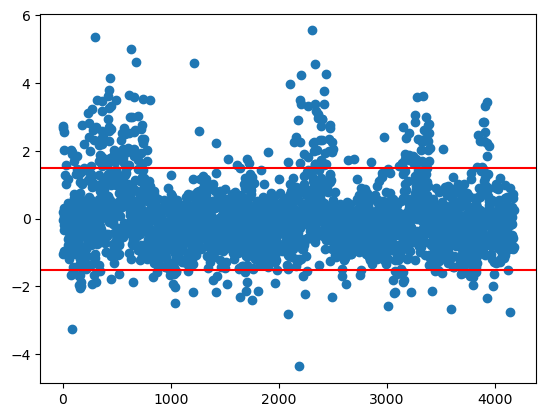

In [698]:
plt.scatter(x_train.index, standardized_residuals)
plt.axhline(1.5, c='r')
plt.axhline(-1.5, c='r')
plt.show()

## 6.2 Check Outliers

### - Jackknife residuals

In [699]:
model_summary = OLSInfluence(lm_reg).summary_frame()
model_summary[abs(model_summary['student_resid'])>3].shape

(42, 15)

Text(0.5, 1.0, 'Jackknife residuals')

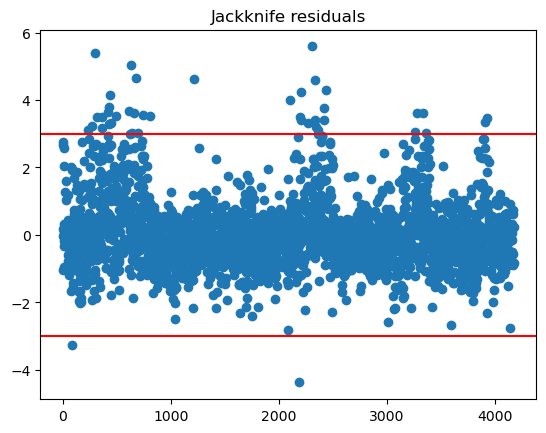

In [700]:
plt.scatter(model_summary.index,model_summary.student_resid)
plt.title("Jackknife residuals")
plt.axhline(3, c='r')
plt.axhline(-3, c='r')
plt.show()

## 6.3 Check Influential Observations


### - Cook's Dist

In [701]:
model_summary[model_summary['cooks_d']>1][['cooks_d']]

,cooks_d


Text(0.5, 1.0, "Cook's Dist")

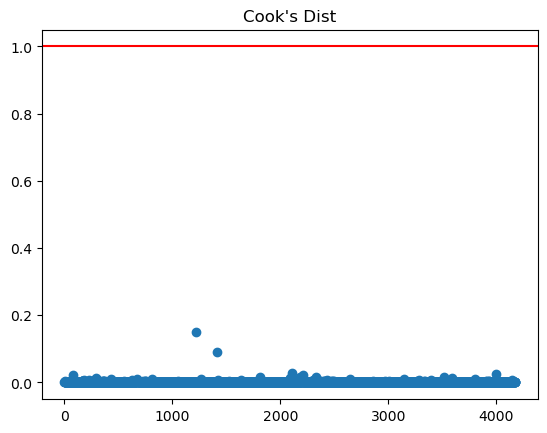

In [702]:
plt.scatter(model_summary.index,model_summary.cooks_d)
plt.title("Cook's Dist")
plt.axhline(1, c='r')
plt.show()

In [703]:
model_summary[['cooks_d']].sort_values("cooks_d")
print("max cook's dist is: ",max(model_summary['cooks_d'].tolist()))

,cooks_d
1668,6.964999e-14
3411,4.142379e-12
705,3.816090e-11
1143,3.183461e-10
3792,4.876096e-10
...,...
81,2.319624e-02
3996,2.536711e-02
2108,2.750857e-02
1417,8.953650e-02


max cook's dist is:  0.14937426771003878


---

## Delete Unusual Observations

In [704]:
unsual_obs = model_summary[(model_summary['hat_diag']>hat_value_point) | (abs(model_summary['student_resid'])>3) 
              | (model_summary['cooks_d']>1) | (abs(model_summary['standard_resid'])>1.5)][['hat_diag','student_resid','cooks_d','standard_resid']].index

In [705]:
unsual_obs.shape

(416,)

In [706]:
# delete unusual observation
df_train_clean = df_train.copy()
df_train_clean_index = df_train_clean.index.tolist()


for i in unsual_obs:
    df_train_clean_index.remove(i)

In [707]:
df_train_clean = df_train_clean.loc[df_train_clean_index,:]

In [708]:
len(df_train_clean)

2257

In [709]:
len(df_train)

2673

# 7. Model Building and Predict

- apply Ridge

In [710]:
# before tuning parameter 
ridge = Ridge(alpha=0.01) 
ridge.fit(df_train_clean.iloc[:,:-1],df_train_clean.iloc[:,-1])

Ridge(alpha=0.01)

In [711]:
ridge_predict = ridge.predict(x_test)

In [712]:
print("MSE:",metrics.mean_squared_error(y_test, ridge_predict))
print("R_2:",r2_score(y_test, ridge_predict))

MSE: 5.2921725299157405
R_2: 0.5008478003472111


- tunning parameter

In [713]:
def get_Mat(dataSet):
    xMat = np.mat(dataSet.iloc[:,:-1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat

def plotShow(dataSet):
    xMat,yMat=get_Mat(dataSet)
    plt.scatter(xMat.A[:,1],yMat.A,c='b',s=5)
    plt.show()
    
def ridgeTest(dataSet,k=30):
    xMat,yMat = get_Mat(dataSet)
    m,n=xMat.shape
    wMat = np.zeros((k,n))
    
    yMean = yMat.mean(0)
    xMeans = xMat.mean(0)
    xVar = xMat.var(0)
    yMat = yMat-yMean
    xMat = (xMat-xMeans)/xVar
    for i in range(k):
        xTx = xMat.T*xMat
        lam = np.exp(i-10)
        denom = xTx+np.eye(n)*lam
        ws = denom.I*(xMat.T*yMat)
        wMat[i,:]=ws.T
    return wMat

In [714]:
k = np.arange(0,30,1)
lam = np.exp(k-10)
wMat = ridgeTest(df_train_clean,k=30)

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

Text(0.5, 0, 'log(α)')

Text(0, 0.5, 'coef')

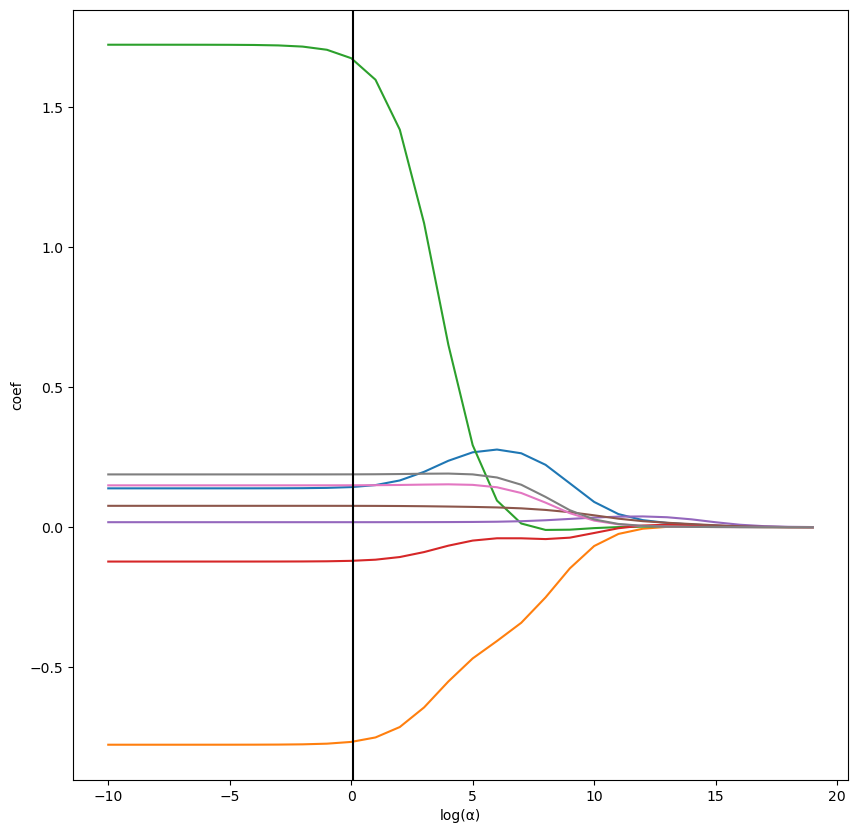

In [715]:
plt.subplots(figsize=(10,10))
plt.plot(np.arange(-10,20,1),wMat)

plt.xlabel('log(α)')
plt.ylabel('coef')
plt.axvline(0.067, c='black')

---

## tunning ridge

In [716]:
mse = []
r2 = []
lambda_list = np.arange(0.001,2,0.001)
for lambda_i in lambda_list:
    reg_tunning = Ridge(alpha=lambda_i) 
    reg_tunning.fit(df_train_clean.iloc[:,:-1],df_train_clean.iloc[:,-1])
    
    reg_predict = reg_tunning.predict(x_test)
    
    mse.append(metrics.mean_squared_error(y_test, reg_predict))
    r2.append(r2_score(y_test, reg_predict))

Ridge(alpha=0.001)

Ridge(alpha=0.002)

Ridge(alpha=0.003)

Ridge(alpha=0.004)

Ridge(alpha=0.005)

Ridge(alpha=0.006)

Ridge(alpha=0.007)

Ridge(alpha=0.008)

Ridge(alpha=0.009000000000000001)

Ridge(alpha=0.010000000000000002)

Ridge(alpha=0.011)

Ridge(alpha=0.012)

Ridge(alpha=0.013000000000000001)

Ridge(alpha=0.014000000000000002)

Ridge(alpha=0.015)

Ridge(alpha=0.016)

Ridge(alpha=0.017)

Ridge(alpha=0.018000000000000002)

Ridge(alpha=0.019000000000000003)

Ridge(alpha=0.02)

Ridge(alpha=0.021)

Ridge(alpha=0.022000000000000002)

Ridge(alpha=0.023)

Ridge(alpha=0.024)

Ridge(alpha=0.025)

Ridge(alpha=0.026000000000000002)

Ridge(alpha=0.027000000000000003)

Ridge(alpha=0.028)

Ridge(alpha=0.029)

Ridge(alpha=0.030000000000000002)

Ridge(alpha=0.031)

Ridge(alpha=0.032)

Ridge(alpha=0.033)

Ridge(alpha=0.034)

Ridge(alpha=0.035)

Ridge(alpha=0.036000000000000004)

Ridge(alpha=0.037000000000000005)

Ridge(alpha=0.038)

Ridge(alpha=0.039)

Ridge(alpha=0.04)

Ridge(alpha=0.041)

Ridge(alpha=0.042)

Ridge(alpha=0.043000000000000003)

Ridge(alpha=0.044000000000000004)

Ridge(alpha=0.045)

Ridge(alpha=0.046)

Ridge(alpha=0.047)

Ridge(alpha=0.048)

Ridge(alpha=0.049)

Ridge(alpha=0.05)

Ridge(alpha=0.051000000000000004)

Ridge(alpha=0.052000000000000005)

Ridge(alpha=0.053000000000000005)

Ridge(alpha=0.054)

Ridge(alpha=0.055)

Ridge(alpha=0.056)

Ridge(alpha=0.057)

Ridge(alpha=0.058)

Ridge(alpha=0.059000000000000004)

Ridge(alpha=0.060000000000000005)

Ridge(alpha=0.061)

Ridge(alpha=0.062)

Ridge(alpha=0.063)

Ridge(alpha=0.064)

Ridge(alpha=0.065)

Ridge(alpha=0.066)

Ridge(alpha=0.067)

Ridge(alpha=0.068)

Ridge(alpha=0.069)

Ridge(alpha=0.07)

Ridge(alpha=0.07100000000000001)

Ridge(alpha=0.07200000000000001)

Ridge(alpha=0.07300000000000001)

Ridge(alpha=0.074)

Ridge(alpha=0.075)

Ridge(alpha=0.076)

Ridge(alpha=0.077)

Ridge(alpha=0.078)

Ridge(alpha=0.079)

Ridge(alpha=0.08)

Ridge(alpha=0.081)

Ridge(alpha=0.082)

Ridge(alpha=0.083)

Ridge(alpha=0.084)

Ridge(alpha=0.085)

Ridge(alpha=0.08600000000000001)

Ridge(alpha=0.08700000000000001)

Ridge(alpha=0.08800000000000001)

Ridge(alpha=0.089)

Ridge(alpha=0.09)

Ridge(alpha=0.091)

Ridge(alpha=0.092)

Ridge(alpha=0.093)

Ridge(alpha=0.094)

Ridge(alpha=0.095)

Ridge(alpha=0.096)

Ridge(alpha=0.097)

Ridge(alpha=0.098)

Ridge(alpha=0.099)

Ridge(alpha=0.1)

Ridge(alpha=0.101)

Ridge(alpha=0.10200000000000001)

Ridge(alpha=0.10300000000000001)

Ridge(alpha=0.10400000000000001)

Ridge(alpha=0.10500000000000001)

Ridge(alpha=0.106)

Ridge(alpha=0.107)

Ridge(alpha=0.108)

Ridge(alpha=0.109)

Ridge(alpha=0.11)

Ridge(alpha=0.111)

Ridge(alpha=0.112)

Ridge(alpha=0.113)

Ridge(alpha=0.114)

Ridge(alpha=0.115)

Ridge(alpha=0.116)

Ridge(alpha=0.117)

Ridge(alpha=0.11800000000000001)

Ridge(alpha=0.11900000000000001)

Ridge(alpha=0.12000000000000001)

Ridge(alpha=0.121)

Ridge(alpha=0.122)

Ridge(alpha=0.123)

Ridge(alpha=0.124)

Ridge(alpha=0.125)

Ridge(alpha=0.126)

Ridge(alpha=0.127)

Ridge(alpha=0.128)

Ridge(alpha=0.129)

Ridge(alpha=0.13)

Ridge(alpha=0.131)

Ridge(alpha=0.132)

Ridge(alpha=0.133)

Ridge(alpha=0.134)

Ridge(alpha=0.135)

Ridge(alpha=0.136)

Ridge(alpha=0.137)

Ridge(alpha=0.138)

Ridge(alpha=0.139)

Ridge(alpha=0.14)

Ridge(alpha=0.14100000000000001)

Ridge(alpha=0.14200000000000002)

Ridge(alpha=0.14300000000000002)

Ridge(alpha=0.14400000000000002)

Ridge(alpha=0.14500000000000002)

Ridge(alpha=0.146)

Ridge(alpha=0.147)

Ridge(alpha=0.148)

Ridge(alpha=0.149)

Ridge(alpha=0.15)

Ridge(alpha=0.151)

Ridge(alpha=0.152)

Ridge(alpha=0.153)

Ridge(alpha=0.154)

Ridge(alpha=0.155)

Ridge(alpha=0.156)

Ridge(alpha=0.157)

Ridge(alpha=0.158)

Ridge(alpha=0.159)

Ridge(alpha=0.16)

Ridge(alpha=0.161)

Ridge(alpha=0.162)

Ridge(alpha=0.163)

Ridge(alpha=0.164)

Ridge(alpha=0.165)

Ridge(alpha=0.166)

Ridge(alpha=0.167)

Ridge(alpha=0.168)

Ridge(alpha=0.169)

Ridge(alpha=0.17)

Ridge(alpha=0.171)

Ridge(alpha=0.17200000000000001)

Ridge(alpha=0.17300000000000001)

Ridge(alpha=0.17400000000000002)

Ridge(alpha=0.17500000000000002)

Ridge(alpha=0.17600000000000002)

Ridge(alpha=0.177)

Ridge(alpha=0.178)

Ridge(alpha=0.179)

Ridge(alpha=0.18)

Ridge(alpha=0.181)

Ridge(alpha=0.182)

Ridge(alpha=0.183)

Ridge(alpha=0.184)

Ridge(alpha=0.185)

Ridge(alpha=0.186)

Ridge(alpha=0.187)

Ridge(alpha=0.188)

Ridge(alpha=0.189)

Ridge(alpha=0.19)

Ridge(alpha=0.191)

Ridge(alpha=0.192)

Ridge(alpha=0.193)

Ridge(alpha=0.194)

Ridge(alpha=0.195)

Ridge(alpha=0.196)

Ridge(alpha=0.197)

Ridge(alpha=0.198)

Ridge(alpha=0.199)

Ridge(alpha=0.2)

Ridge(alpha=0.201)

Ridge(alpha=0.202)

Ridge(alpha=0.203)

Ridge(alpha=0.20400000000000001)

Ridge(alpha=0.20500000000000002)

Ridge(alpha=0.20600000000000002)

Ridge(alpha=0.20700000000000002)

Ridge(alpha=0.20800000000000002)

Ridge(alpha=0.20900000000000002)

Ridge(alpha=0.21)

Ridge(alpha=0.211)

Ridge(alpha=0.212)

Ridge(alpha=0.213)

Ridge(alpha=0.214)

Ridge(alpha=0.215)

Ridge(alpha=0.216)

Ridge(alpha=0.217)

Ridge(alpha=0.218)

Ridge(alpha=0.219)

Ridge(alpha=0.22)

Ridge(alpha=0.221)

Ridge(alpha=0.222)

Ridge(alpha=0.223)

Ridge(alpha=0.224)

Ridge(alpha=0.225)

Ridge(alpha=0.226)

Ridge(alpha=0.227)

Ridge(alpha=0.228)

Ridge(alpha=0.229)

Ridge(alpha=0.23)

Ridge(alpha=0.231)

Ridge(alpha=0.232)

Ridge(alpha=0.233)

Ridge(alpha=0.234)

Ridge(alpha=0.23500000000000001)

Ridge(alpha=0.23600000000000002)

Ridge(alpha=0.23700000000000002)

Ridge(alpha=0.23800000000000002)

Ridge(alpha=0.23900000000000002)

Ridge(alpha=0.24000000000000002)

Ridge(alpha=0.241)

Ridge(alpha=0.242)

Ridge(alpha=0.243)

Ridge(alpha=0.244)

Ridge(alpha=0.245)

Ridge(alpha=0.246)

Ridge(alpha=0.247)

Ridge(alpha=0.248)

Ridge(alpha=0.249)

Ridge(alpha=0.25)

Ridge(alpha=0.251)

Ridge(alpha=0.252)

Ridge(alpha=0.253)

Ridge(alpha=0.254)

Ridge(alpha=0.255)

Ridge(alpha=0.256)

Ridge(alpha=0.257)

Ridge(alpha=0.258)

Ridge(alpha=0.259)

Ridge(alpha=0.26)

Ridge(alpha=0.261)

Ridge(alpha=0.262)

Ridge(alpha=0.263)

Ridge(alpha=0.264)

Ridge(alpha=0.265)

Ridge(alpha=0.266)

Ridge(alpha=0.267)

Ridge(alpha=0.268)

Ridge(alpha=0.269)

Ridge(alpha=0.27)

Ridge(alpha=0.271)

Ridge(alpha=0.272)

Ridge(alpha=0.273)

Ridge(alpha=0.274)

Ridge(alpha=0.275)

Ridge(alpha=0.276)

Ridge(alpha=0.277)

Ridge(alpha=0.278)

Ridge(alpha=0.279)

Ridge(alpha=0.28)

Ridge(alpha=0.281)

Ridge(alpha=0.28200000000000003)

Ridge(alpha=0.28300000000000003)

Ridge(alpha=0.28400000000000003)

Ridge(alpha=0.28500000000000003)

Ridge(alpha=0.28600000000000003)

Ridge(alpha=0.28700000000000003)

Ridge(alpha=0.28800000000000003)

Ridge(alpha=0.28900000000000003)

Ridge(alpha=0.29)

Ridge(alpha=0.291)

Ridge(alpha=0.292)

Ridge(alpha=0.293)

Ridge(alpha=0.294)

Ridge(alpha=0.295)

Ridge(alpha=0.296)

Ridge(alpha=0.297)

Ridge(alpha=0.298)

Ridge(alpha=0.299)

Ridge(alpha=0.3)

Ridge(alpha=0.301)

Ridge(alpha=0.302)

Ridge(alpha=0.303)

Ridge(alpha=0.304)

Ridge(alpha=0.305)

Ridge(alpha=0.306)

Ridge(alpha=0.307)

Ridge(alpha=0.308)

Ridge(alpha=0.309)

Ridge(alpha=0.31)

Ridge(alpha=0.311)

Ridge(alpha=0.312)

Ridge(alpha=0.313)

Ridge(alpha=0.314)

Ridge(alpha=0.315)

Ridge(alpha=0.316)

Ridge(alpha=0.317)

Ridge(alpha=0.318)

Ridge(alpha=0.319)

Ridge(alpha=0.32)

Ridge(alpha=0.321)

Ridge(alpha=0.322)

Ridge(alpha=0.323)

Ridge(alpha=0.324)

Ridge(alpha=0.325)

Ridge(alpha=0.326)

Ridge(alpha=0.327)

Ridge(alpha=0.328)

Ridge(alpha=0.329)

Ridge(alpha=0.33)

Ridge(alpha=0.331)

Ridge(alpha=0.332)

Ridge(alpha=0.333)

Ridge(alpha=0.334)

Ridge(alpha=0.335)

Ridge(alpha=0.336)

Ridge(alpha=0.337)

Ridge(alpha=0.338)

Ridge(alpha=0.339)

Ridge(alpha=0.34)

Ridge(alpha=0.341)

Ridge(alpha=0.342)

Ridge(alpha=0.343)

Ridge(alpha=0.34400000000000003)

Ridge(alpha=0.34500000000000003)

Ridge(alpha=0.34600000000000003)

Ridge(alpha=0.34700000000000003)

Ridge(alpha=0.34800000000000003)

Ridge(alpha=0.34900000000000003)

Ridge(alpha=0.35000000000000003)

Ridge(alpha=0.35100000000000003)

Ridge(alpha=0.35200000000000004)

Ridge(alpha=0.353)

Ridge(alpha=0.354)

Ridge(alpha=0.355)

Ridge(alpha=0.356)

Ridge(alpha=0.357)

Ridge(alpha=0.358)

Ridge(alpha=0.359)

Ridge(alpha=0.36)

Ridge(alpha=0.361)

Ridge(alpha=0.362)

Ridge(alpha=0.363)

Ridge(alpha=0.364)

Ridge(alpha=0.365)

Ridge(alpha=0.366)

Ridge(alpha=0.367)

Ridge(alpha=0.368)

Ridge(alpha=0.369)

Ridge(alpha=0.37)

Ridge(alpha=0.371)

Ridge(alpha=0.372)

Ridge(alpha=0.373)

Ridge(alpha=0.374)

Ridge(alpha=0.375)

Ridge(alpha=0.376)

Ridge(alpha=0.377)

Ridge(alpha=0.378)

Ridge(alpha=0.379)

Ridge(alpha=0.38)

Ridge(alpha=0.381)

Ridge(alpha=0.382)

Ridge(alpha=0.383)

Ridge(alpha=0.384)

Ridge(alpha=0.385)

Ridge(alpha=0.386)

Ridge(alpha=0.387)

Ridge(alpha=0.388)

Ridge(alpha=0.389)

Ridge(alpha=0.39)

Ridge(alpha=0.391)

Ridge(alpha=0.392)

Ridge(alpha=0.393)

Ridge(alpha=0.394)

Ridge(alpha=0.395)

Ridge(alpha=0.396)

Ridge(alpha=0.397)

Ridge(alpha=0.398)

Ridge(alpha=0.399)

Ridge(alpha=0.4)

Ridge(alpha=0.401)

Ridge(alpha=0.402)

Ridge(alpha=0.403)

Ridge(alpha=0.404)

Ridge(alpha=0.405)

Ridge(alpha=0.406)

Ridge(alpha=0.40700000000000003)

Ridge(alpha=0.40800000000000003)

Ridge(alpha=0.40900000000000003)

Ridge(alpha=0.41000000000000003)

Ridge(alpha=0.41100000000000003)

Ridge(alpha=0.41200000000000003)

Ridge(alpha=0.41300000000000003)

Ridge(alpha=0.41400000000000003)

Ridge(alpha=0.41500000000000004)

Ridge(alpha=0.41600000000000004)

Ridge(alpha=0.41700000000000004)

Ridge(alpha=0.418)

Ridge(alpha=0.419)

Ridge(alpha=0.42)

Ridge(alpha=0.421)

Ridge(alpha=0.422)

Ridge(alpha=0.423)

Ridge(alpha=0.424)

Ridge(alpha=0.425)

Ridge(alpha=0.426)

Ridge(alpha=0.427)

Ridge(alpha=0.428)

Ridge(alpha=0.429)

Ridge(alpha=0.43)

Ridge(alpha=0.431)

Ridge(alpha=0.432)

Ridge(alpha=0.433)

Ridge(alpha=0.434)

Ridge(alpha=0.435)

Ridge(alpha=0.436)

Ridge(alpha=0.437)

Ridge(alpha=0.438)

Ridge(alpha=0.439)

Ridge(alpha=0.44)

Ridge(alpha=0.441)

Ridge(alpha=0.442)

Ridge(alpha=0.443)

Ridge(alpha=0.444)

Ridge(alpha=0.445)

Ridge(alpha=0.446)

Ridge(alpha=0.447)

Ridge(alpha=0.448)

Ridge(alpha=0.449)

Ridge(alpha=0.45)

Ridge(alpha=0.451)

Ridge(alpha=0.452)

Ridge(alpha=0.453)

Ridge(alpha=0.454)

Ridge(alpha=0.455)

Ridge(alpha=0.456)

Ridge(alpha=0.457)

Ridge(alpha=0.458)

Ridge(alpha=0.459)

Ridge(alpha=0.46)

Ridge(alpha=0.461)

Ridge(alpha=0.462)

Ridge(alpha=0.463)

Ridge(alpha=0.464)

Ridge(alpha=0.465)

Ridge(alpha=0.466)

Ridge(alpha=0.467)

Ridge(alpha=0.468)

Ridge(alpha=0.46900000000000003)

Ridge(alpha=0.47000000000000003)

Ridge(alpha=0.47100000000000003)

Ridge(alpha=0.47200000000000003)

Ridge(alpha=0.47300000000000003)

Ridge(alpha=0.47400000000000003)

Ridge(alpha=0.47500000000000003)

Ridge(alpha=0.47600000000000003)

Ridge(alpha=0.47700000000000004)

Ridge(alpha=0.47800000000000004)

Ridge(alpha=0.47900000000000004)

Ridge(alpha=0.48000000000000004)

Ridge(alpha=0.481)

Ridge(alpha=0.482)

Ridge(alpha=0.483)

Ridge(alpha=0.484)

Ridge(alpha=0.485)

Ridge(alpha=0.486)

Ridge(alpha=0.487)

Ridge(alpha=0.488)

Ridge(alpha=0.489)

Ridge(alpha=0.49)

Ridge(alpha=0.491)

Ridge(alpha=0.492)

Ridge(alpha=0.493)

Ridge(alpha=0.494)

Ridge(alpha=0.495)

Ridge(alpha=0.496)

Ridge(alpha=0.497)

Ridge(alpha=0.498)

Ridge(alpha=0.499)

Ridge(alpha=0.5)

Ridge(alpha=0.501)

Ridge(alpha=0.502)

Ridge(alpha=0.503)

Ridge(alpha=0.504)

Ridge(alpha=0.505)

Ridge(alpha=0.506)

Ridge(alpha=0.507)

Ridge(alpha=0.508)

Ridge(alpha=0.509)

Ridge(alpha=0.51)

Ridge(alpha=0.511)

Ridge(alpha=0.512)

Ridge(alpha=0.513)

Ridge(alpha=0.514)

Ridge(alpha=0.515)

Ridge(alpha=0.516)

Ridge(alpha=0.517)

Ridge(alpha=0.518)

Ridge(alpha=0.519)

Ridge(alpha=0.52)

Ridge(alpha=0.521)

Ridge(alpha=0.522)

Ridge(alpha=0.523)

Ridge(alpha=0.524)

Ridge(alpha=0.525)

Ridge(alpha=0.526)

Ridge(alpha=0.527)

Ridge(alpha=0.528)

Ridge(alpha=0.529)

Ridge(alpha=0.53)

Ridge(alpha=0.531)

Ridge(alpha=0.532)

Ridge(alpha=0.533)

Ridge(alpha=0.534)

Ridge(alpha=0.535)

Ridge(alpha=0.536)

Ridge(alpha=0.537)

Ridge(alpha=0.538)

Ridge(alpha=0.539)

Ridge(alpha=0.54)

Ridge(alpha=0.541)

Ridge(alpha=0.542)

Ridge(alpha=0.543)

Ridge(alpha=0.544)

Ridge(alpha=0.545)

Ridge(alpha=0.546)

Ridge(alpha=0.547)

Ridge(alpha=0.548)

Ridge(alpha=0.549)

Ridge(alpha=0.55)

Ridge(alpha=0.551)

Ridge(alpha=0.552)

Ridge(alpha=0.553)

Ridge(alpha=0.554)

Ridge(alpha=0.555)

Ridge(alpha=0.556)

Ridge(alpha=0.557)

Ridge(alpha=0.558)

Ridge(alpha=0.559)

Ridge(alpha=0.56)

Ridge(alpha=0.561)

Ridge(alpha=0.562)

Ridge(alpha=0.5630000000000001)

Ridge(alpha=0.5640000000000001)

Ridge(alpha=0.5650000000000001)

Ridge(alpha=0.5660000000000001)

Ridge(alpha=0.5670000000000001)

Ridge(alpha=0.5680000000000001)

Ridge(alpha=0.5690000000000001)

Ridge(alpha=0.5700000000000001)

Ridge(alpha=0.5710000000000001)

Ridge(alpha=0.5720000000000001)

Ridge(alpha=0.5730000000000001)

Ridge(alpha=0.5740000000000001)

Ridge(alpha=0.5750000000000001)

Ridge(alpha=0.5760000000000001)

Ridge(alpha=0.5770000000000001)

Ridge(alpha=0.578)

Ridge(alpha=0.579)

Ridge(alpha=0.58)

Ridge(alpha=0.581)

Ridge(alpha=0.582)

Ridge(alpha=0.583)

Ridge(alpha=0.584)

Ridge(alpha=0.585)

Ridge(alpha=0.586)

Ridge(alpha=0.587)

Ridge(alpha=0.588)

Ridge(alpha=0.589)

Ridge(alpha=0.59)

Ridge(alpha=0.591)

Ridge(alpha=0.592)

Ridge(alpha=0.593)

Ridge(alpha=0.594)

Ridge(alpha=0.595)

Ridge(alpha=0.596)

Ridge(alpha=0.597)

Ridge(alpha=0.598)

Ridge(alpha=0.599)

Ridge(alpha=0.6)

Ridge(alpha=0.601)

Ridge(alpha=0.602)

Ridge(alpha=0.603)

Ridge(alpha=0.604)

Ridge(alpha=0.605)

Ridge(alpha=0.606)

Ridge(alpha=0.607)

Ridge(alpha=0.608)

Ridge(alpha=0.609)

Ridge(alpha=0.61)

Ridge(alpha=0.611)

Ridge(alpha=0.612)

Ridge(alpha=0.613)

Ridge(alpha=0.614)

Ridge(alpha=0.615)

Ridge(alpha=0.616)

Ridge(alpha=0.617)

Ridge(alpha=0.618)

Ridge(alpha=0.619)

Ridge(alpha=0.62)

Ridge(alpha=0.621)

Ridge(alpha=0.622)

Ridge(alpha=0.623)

Ridge(alpha=0.624)

Ridge(alpha=0.625)

Ridge(alpha=0.626)

Ridge(alpha=0.627)

Ridge(alpha=0.628)

Ridge(alpha=0.629)

Ridge(alpha=0.63)

Ridge(alpha=0.631)

Ridge(alpha=0.632)

Ridge(alpha=0.633)

Ridge(alpha=0.634)

Ridge(alpha=0.635)

Ridge(alpha=0.636)

Ridge(alpha=0.637)

Ridge(alpha=0.638)

Ridge(alpha=0.639)

Ridge(alpha=0.64)

Ridge(alpha=0.641)

Ridge(alpha=0.642)

Ridge(alpha=0.643)

Ridge(alpha=0.644)

Ridge(alpha=0.645)

Ridge(alpha=0.646)

Ridge(alpha=0.647)

Ridge(alpha=0.648)

Ridge(alpha=0.649)

Ridge(alpha=0.65)

Ridge(alpha=0.651)

Ridge(alpha=0.652)

Ridge(alpha=0.653)

Ridge(alpha=0.654)

Ridge(alpha=0.655)

Ridge(alpha=0.656)

Ridge(alpha=0.657)

Ridge(alpha=0.658)

Ridge(alpha=0.659)

Ridge(alpha=0.66)

Ridge(alpha=0.661)

Ridge(alpha=0.662)

Ridge(alpha=0.663)

Ridge(alpha=0.664)

Ridge(alpha=0.665)

Ridge(alpha=0.666)

Ridge(alpha=0.667)

Ridge(alpha=0.668)

Ridge(alpha=0.669)

Ridge(alpha=0.67)

Ridge(alpha=0.671)

Ridge(alpha=0.672)

Ridge(alpha=0.673)

Ridge(alpha=0.674)

Ridge(alpha=0.675)

Ridge(alpha=0.676)

Ridge(alpha=0.677)

Ridge(alpha=0.678)

Ridge(alpha=0.679)

Ridge(alpha=0.68)

Ridge(alpha=0.681)

Ridge(alpha=0.682)

Ridge(alpha=0.683)

Ridge(alpha=0.684)

Ridge(alpha=0.685)

Ridge(alpha=0.686)

Ridge(alpha=0.687)

Ridge(alpha=0.6880000000000001)

Ridge(alpha=0.6890000000000001)

Ridge(alpha=0.6900000000000001)

Ridge(alpha=0.6910000000000001)

Ridge(alpha=0.6920000000000001)

Ridge(alpha=0.6930000000000001)

Ridge(alpha=0.6940000000000001)

Ridge(alpha=0.6950000000000001)

Ridge(alpha=0.6960000000000001)

Ridge(alpha=0.6970000000000001)

Ridge(alpha=0.6980000000000001)

Ridge(alpha=0.6990000000000001)

Ridge(alpha=0.7000000000000001)

Ridge(alpha=0.7010000000000001)

Ridge(alpha=0.7020000000000001)

Ridge(alpha=0.7030000000000001)

Ridge(alpha=0.7040000000000001)

Ridge(alpha=0.705)

Ridge(alpha=0.706)

Ridge(alpha=0.707)

Ridge(alpha=0.708)

Ridge(alpha=0.709)

Ridge(alpha=0.71)

Ridge(alpha=0.711)

Ridge(alpha=0.712)

Ridge(alpha=0.713)

Ridge(alpha=0.714)

Ridge(alpha=0.715)

Ridge(alpha=0.716)

Ridge(alpha=0.717)

Ridge(alpha=0.718)

Ridge(alpha=0.719)

Ridge(alpha=0.72)

Ridge(alpha=0.721)

Ridge(alpha=0.722)

Ridge(alpha=0.723)

Ridge(alpha=0.724)

Ridge(alpha=0.725)

Ridge(alpha=0.726)

Ridge(alpha=0.727)

Ridge(alpha=0.728)

Ridge(alpha=0.729)

Ridge(alpha=0.73)

Ridge(alpha=0.731)

Ridge(alpha=0.732)

Ridge(alpha=0.733)

Ridge(alpha=0.734)

Ridge(alpha=0.735)

Ridge(alpha=0.736)

Ridge(alpha=0.737)

Ridge(alpha=0.738)

Ridge(alpha=0.739)

Ridge(alpha=0.74)

Ridge(alpha=0.741)

Ridge(alpha=0.742)

Ridge(alpha=0.743)

Ridge(alpha=0.744)

Ridge(alpha=0.745)

Ridge(alpha=0.746)

Ridge(alpha=0.747)

Ridge(alpha=0.748)

Ridge(alpha=0.749)

Ridge(alpha=0.75)

Ridge(alpha=0.751)

Ridge(alpha=0.752)

Ridge(alpha=0.753)

Ridge(alpha=0.754)

Ridge(alpha=0.755)

Ridge(alpha=0.756)

Ridge(alpha=0.757)

Ridge(alpha=0.758)

Ridge(alpha=0.759)

Ridge(alpha=0.76)

Ridge(alpha=0.761)

Ridge(alpha=0.762)

Ridge(alpha=0.763)

Ridge(alpha=0.764)

Ridge(alpha=0.765)

Ridge(alpha=0.766)

Ridge(alpha=0.767)

Ridge(alpha=0.768)

Ridge(alpha=0.769)

Ridge(alpha=0.77)

Ridge(alpha=0.771)

Ridge(alpha=0.772)

Ridge(alpha=0.773)

Ridge(alpha=0.774)

Ridge(alpha=0.775)

Ridge(alpha=0.776)

Ridge(alpha=0.777)

Ridge(alpha=0.778)

Ridge(alpha=0.779)

Ridge(alpha=0.78)

Ridge(alpha=0.781)

Ridge(alpha=0.782)

Ridge(alpha=0.783)

Ridge(alpha=0.784)

Ridge(alpha=0.785)

Ridge(alpha=0.786)

Ridge(alpha=0.787)

Ridge(alpha=0.788)

Ridge(alpha=0.789)

Ridge(alpha=0.79)

Ridge(alpha=0.791)

Ridge(alpha=0.792)

Ridge(alpha=0.793)

Ridge(alpha=0.794)

Ridge(alpha=0.795)

Ridge(alpha=0.796)

Ridge(alpha=0.797)

Ridge(alpha=0.798)

Ridge(alpha=0.799)

Ridge(alpha=0.8)

Ridge(alpha=0.801)

Ridge(alpha=0.802)

Ridge(alpha=0.803)

Ridge(alpha=0.804)

Ridge(alpha=0.805)

Ridge(alpha=0.806)

Ridge(alpha=0.807)

Ridge(alpha=0.808)

Ridge(alpha=0.809)

Ridge(alpha=0.81)

Ridge(alpha=0.811)

Ridge(alpha=0.812)

Ridge(alpha=0.8130000000000001)

Ridge(alpha=0.8140000000000001)

Ridge(alpha=0.8150000000000001)

Ridge(alpha=0.8160000000000001)

Ridge(alpha=0.8170000000000001)

Ridge(alpha=0.8180000000000001)

Ridge(alpha=0.8190000000000001)

Ridge(alpha=0.8200000000000001)

Ridge(alpha=0.8210000000000001)

Ridge(alpha=0.8220000000000001)

Ridge(alpha=0.8230000000000001)

Ridge(alpha=0.8240000000000001)

Ridge(alpha=0.8250000000000001)

Ridge(alpha=0.8260000000000001)

Ridge(alpha=0.8270000000000001)

Ridge(alpha=0.8280000000000001)

Ridge(alpha=0.8290000000000001)

Ridge(alpha=0.8300000000000001)

Ridge(alpha=0.8310000000000001)

Ridge(alpha=0.8320000000000001)

Ridge(alpha=0.8330000000000001)

Ridge(alpha=0.834)

Ridge(alpha=0.835)

Ridge(alpha=0.836)

Ridge(alpha=0.837)

Ridge(alpha=0.838)

Ridge(alpha=0.839)

Ridge(alpha=0.84)

Ridge(alpha=0.841)

Ridge(alpha=0.842)

Ridge(alpha=0.843)

Ridge(alpha=0.844)

Ridge(alpha=0.845)

Ridge(alpha=0.846)

Ridge(alpha=0.847)

Ridge(alpha=0.848)

Ridge(alpha=0.849)

Ridge(alpha=0.85)

Ridge(alpha=0.851)

Ridge(alpha=0.852)

Ridge(alpha=0.853)

Ridge(alpha=0.854)

Ridge(alpha=0.855)

Ridge(alpha=0.856)

Ridge(alpha=0.857)

Ridge(alpha=0.858)

Ridge(alpha=0.859)

Ridge(alpha=0.86)

Ridge(alpha=0.861)

Ridge(alpha=0.862)

Ridge(alpha=0.863)

Ridge(alpha=0.864)

Ridge(alpha=0.865)

Ridge(alpha=0.866)

Ridge(alpha=0.867)

Ridge(alpha=0.868)

Ridge(alpha=0.869)

Ridge(alpha=0.87)

Ridge(alpha=0.871)

Ridge(alpha=0.872)

Ridge(alpha=0.873)

Ridge(alpha=0.874)

Ridge(alpha=0.875)

Ridge(alpha=0.876)

Ridge(alpha=0.877)

Ridge(alpha=0.878)

Ridge(alpha=0.879)

Ridge(alpha=0.88)

Ridge(alpha=0.881)

Ridge(alpha=0.882)

Ridge(alpha=0.883)

Ridge(alpha=0.884)

Ridge(alpha=0.885)

Ridge(alpha=0.886)

Ridge(alpha=0.887)

Ridge(alpha=0.888)

Ridge(alpha=0.889)

Ridge(alpha=0.89)

Ridge(alpha=0.891)

Ridge(alpha=0.892)

Ridge(alpha=0.893)

Ridge(alpha=0.894)

Ridge(alpha=0.895)

Ridge(alpha=0.896)

Ridge(alpha=0.897)

Ridge(alpha=0.898)

Ridge(alpha=0.899)

Ridge(alpha=0.9)

Ridge(alpha=0.901)

Ridge(alpha=0.902)

Ridge(alpha=0.903)

Ridge(alpha=0.904)

Ridge(alpha=0.905)

Ridge(alpha=0.906)

Ridge(alpha=0.907)

Ridge(alpha=0.908)

Ridge(alpha=0.909)

Ridge(alpha=0.91)

Ridge(alpha=0.911)

Ridge(alpha=0.912)

Ridge(alpha=0.913)

Ridge(alpha=0.914)

Ridge(alpha=0.915)

Ridge(alpha=0.916)

Ridge(alpha=0.917)

Ridge(alpha=0.918)

Ridge(alpha=0.919)

Ridge(alpha=0.92)

Ridge(alpha=0.921)

Ridge(alpha=0.922)

Ridge(alpha=0.923)

Ridge(alpha=0.924)

Ridge(alpha=0.925)

Ridge(alpha=0.926)

Ridge(alpha=0.927)

Ridge(alpha=0.928)

Ridge(alpha=0.929)

Ridge(alpha=0.93)

Ridge(alpha=0.931)

Ridge(alpha=0.932)

Ridge(alpha=0.933)

Ridge(alpha=0.934)

Ridge(alpha=0.935)

Ridge(alpha=0.936)

Ridge(alpha=0.937)

Ridge(alpha=0.9380000000000001)

Ridge(alpha=0.9390000000000001)

Ridge(alpha=0.9400000000000001)

Ridge(alpha=0.9410000000000001)

Ridge(alpha=0.9420000000000001)

Ridge(alpha=0.9430000000000001)

Ridge(alpha=0.9440000000000001)

Ridge(alpha=0.9450000000000001)

Ridge(alpha=0.9460000000000001)

Ridge(alpha=0.9470000000000001)

Ridge(alpha=0.9480000000000001)

Ridge(alpha=0.9490000000000001)

Ridge(alpha=0.9500000000000001)

Ridge(alpha=0.9510000000000001)

Ridge(alpha=0.9520000000000001)

Ridge(alpha=0.9530000000000001)

Ridge(alpha=0.9540000000000001)

Ridge(alpha=0.9550000000000001)

Ridge(alpha=0.9560000000000001)

Ridge(alpha=0.9570000000000001)

Ridge(alpha=0.9580000000000001)

Ridge(alpha=0.9590000000000001)

Ridge(alpha=0.9600000000000001)

Ridge(alpha=0.961)

Ridge(alpha=0.962)

Ridge(alpha=0.963)

Ridge(alpha=0.964)

Ridge(alpha=0.965)

Ridge(alpha=0.966)

Ridge(alpha=0.967)

Ridge(alpha=0.968)

Ridge(alpha=0.969)

Ridge(alpha=0.97)

Ridge(alpha=0.971)

Ridge(alpha=0.972)

Ridge(alpha=0.973)

Ridge(alpha=0.974)

Ridge(alpha=0.975)

Ridge(alpha=0.976)

Ridge(alpha=0.977)

Ridge(alpha=0.978)

Ridge(alpha=0.979)

Ridge(alpha=0.98)

Ridge(alpha=0.981)

Ridge(alpha=0.982)

Ridge(alpha=0.983)

Ridge(alpha=0.984)

Ridge(alpha=0.985)

Ridge(alpha=0.986)

Ridge(alpha=0.987)

Ridge(alpha=0.988)

Ridge(alpha=0.989)

Ridge(alpha=0.99)

Ridge(alpha=0.991)

Ridge(alpha=0.992)

Ridge(alpha=0.993)

Ridge(alpha=0.994)

Ridge(alpha=0.995)

Ridge(alpha=0.996)

Ridge(alpha=0.997)

Ridge(alpha=0.998)

Ridge(alpha=0.999)

Ridge()

Ridge(alpha=1.001)

Ridge(alpha=1.002)

Ridge(alpha=1.003)

Ridge(alpha=1.004)

Ridge(alpha=1.005)

Ridge(alpha=1.006)

Ridge(alpha=1.007)

Ridge(alpha=1.008)

Ridge(alpha=1.009)

Ridge(alpha=1.01)

Ridge(alpha=1.011)

Ridge(alpha=1.012)

Ridge(alpha=1.013)

Ridge(alpha=1.014)

Ridge(alpha=1.015)

Ridge(alpha=1.016)

Ridge(alpha=1.017)

Ridge(alpha=1.018)

Ridge(alpha=1.019)

Ridge(alpha=1.02)

Ridge(alpha=1.021)

Ridge(alpha=1.022)

Ridge(alpha=1.023)

Ridge(alpha=1.024)

Ridge(alpha=1.025)

Ridge(alpha=1.0259999999999998)

Ridge(alpha=1.027)

Ridge(alpha=1.0279999999999998)

Ridge(alpha=1.029)

Ridge(alpha=1.0299999999999998)

Ridge(alpha=1.031)

Ridge(alpha=1.0319999999999998)

Ridge(alpha=1.033)

Ridge(alpha=1.0339999999999998)

Ridge(alpha=1.035)

Ridge(alpha=1.0359999999999998)

Ridge(alpha=1.037)

Ridge(alpha=1.0379999999999998)

Ridge(alpha=1.039)

Ridge(alpha=1.0399999999999998)

Ridge(alpha=1.041)

Ridge(alpha=1.0419999999999998)

Ridge(alpha=1.043)

Ridge(alpha=1.0439999999999998)

Ridge(alpha=1.045)

Ridge(alpha=1.0459999999999998)

Ridge(alpha=1.047)

Ridge(alpha=1.0479999999999998)

Ridge(alpha=1.049)

Ridge(alpha=1.0499999999999998)

Ridge(alpha=1.051)

Ridge(alpha=1.0519999999999998)

Ridge(alpha=1.053)

Ridge(alpha=1.0539999999999998)

Ridge(alpha=1.055)

Ridge(alpha=1.0559999999999998)

Ridge(alpha=1.057)

Ridge(alpha=1.0579999999999998)

Ridge(alpha=1.059)

Ridge(alpha=1.0599999999999998)

Ridge(alpha=1.061)

Ridge(alpha=1.0619999999999998)

Ridge(alpha=1.063)

Ridge(alpha=1.0639999999999998)

Ridge(alpha=1.065)

Ridge(alpha=1.0659999999999998)

Ridge(alpha=1.067)

Ridge(alpha=1.0679999999999998)

Ridge(alpha=1.069)

Ridge(alpha=1.0699999999999998)

Ridge(alpha=1.071)

Ridge(alpha=1.0719999999999998)

Ridge(alpha=1.073)

Ridge(alpha=1.0739999999999998)

Ridge(alpha=1.075)

Ridge(alpha=1.0759999999999998)

Ridge(alpha=1.077)

Ridge(alpha=1.0779999999999998)

Ridge(alpha=1.079)

Ridge(alpha=1.0799999999999998)

Ridge(alpha=1.081)

Ridge(alpha=1.0819999999999999)

Ridge(alpha=1.083)

Ridge(alpha=1.0839999999999999)

Ridge(alpha=1.085)

Ridge(alpha=1.0859999999999999)

Ridge(alpha=1.087)

Ridge(alpha=1.0879999999999999)

Ridge(alpha=1.089)

Ridge(alpha=1.0899999999999999)

Ridge(alpha=1.091)

Ridge(alpha=1.0919999999999999)

Ridge(alpha=1.093)

Ridge(alpha=1.0939999999999999)

Ridge(alpha=1.095)

Ridge(alpha=1.0959999999999999)

Ridge(alpha=1.097)

Ridge(alpha=1.0979999999999999)

Ridge(alpha=1.099)

Ridge(alpha=1.0999999999999999)

Ridge(alpha=1.101)

Ridge(alpha=1.1019999999999999)

Ridge(alpha=1.103)

Ridge(alpha=1.1039999999999999)

Ridge(alpha=1.105)

Ridge(alpha=1.1059999999999999)

Ridge(alpha=1.107)

Ridge(alpha=1.1079999999999999)

Ridge(alpha=1.109)

Ridge(alpha=1.1099999999999999)

Ridge(alpha=1.111)

Ridge(alpha=1.1119999999999999)

Ridge(alpha=1.113)

Ridge(alpha=1.1139999999999999)

Ridge(alpha=1.115)

Ridge(alpha=1.1159999999999999)

Ridge(alpha=1.117)

Ridge(alpha=1.1179999999999999)

Ridge(alpha=1.119)

Ridge(alpha=1.1199999999999999)

Ridge(alpha=1.121)

Ridge(alpha=1.1219999999999999)

Ridge(alpha=1.123)

Ridge(alpha=1.1239999999999999)

Ridge(alpha=1.125)

Ridge(alpha=1.126)

Ridge(alpha=1.127)

Ridge(alpha=1.128)

Ridge(alpha=1.129)

Ridge(alpha=1.13)

Ridge(alpha=1.131)

Ridge(alpha=1.132)

Ridge(alpha=1.133)

Ridge(alpha=1.134)

Ridge(alpha=1.135)

Ridge(alpha=1.136)

Ridge(alpha=1.137)

Ridge(alpha=1.138)

Ridge(alpha=1.139)

Ridge(alpha=1.14)

Ridge(alpha=1.141)

Ridge(alpha=1.142)

Ridge(alpha=1.143)

Ridge(alpha=1.144)

Ridge(alpha=1.145)

Ridge(alpha=1.146)

Ridge(alpha=1.147)

Ridge(alpha=1.148)

Ridge(alpha=1.149)

Ridge(alpha=1.15)

Ridge(alpha=1.151)

Ridge(alpha=1.152)

Ridge(alpha=1.153)

Ridge(alpha=1.154)

Ridge(alpha=1.1549999999999998)

Ridge(alpha=1.156)

Ridge(alpha=1.1569999999999998)

Ridge(alpha=1.158)

Ridge(alpha=1.1589999999999998)

Ridge(alpha=1.16)

Ridge(alpha=1.1609999999999998)

Ridge(alpha=1.162)

Ridge(alpha=1.1629999999999998)

Ridge(alpha=1.164)

Ridge(alpha=1.1649999999999998)

Ridge(alpha=1.166)

Ridge(alpha=1.1669999999999998)

Ridge(alpha=1.168)

Ridge(alpha=1.1689999999999998)

Ridge(alpha=1.17)

Ridge(alpha=1.1709999999999998)

Ridge(alpha=1.172)

Ridge(alpha=1.1729999999999998)

Ridge(alpha=1.174)

Ridge(alpha=1.1749999999999998)

Ridge(alpha=1.176)

Ridge(alpha=1.1769999999999998)

Ridge(alpha=1.178)

Ridge(alpha=1.1789999999999998)

Ridge(alpha=1.18)

Ridge(alpha=1.1809999999999998)

Ridge(alpha=1.182)

Ridge(alpha=1.1829999999999998)

Ridge(alpha=1.184)

Ridge(alpha=1.1849999999999998)

Ridge(alpha=1.186)

Ridge(alpha=1.1869999999999998)

Ridge(alpha=1.188)

Ridge(alpha=1.1889999999999998)

Ridge(alpha=1.19)

Ridge(alpha=1.1909999999999998)

Ridge(alpha=1.192)

Ridge(alpha=1.1929999999999998)

Ridge(alpha=1.194)

Ridge(alpha=1.1949999999999998)

Ridge(alpha=1.196)

Ridge(alpha=1.1969999999999998)

Ridge(alpha=1.198)

Ridge(alpha=1.1989999999999998)

Ridge(alpha=1.2)

Ridge(alpha=1.2009999999999998)

Ridge(alpha=1.202)

Ridge(alpha=1.2029999999999998)

Ridge(alpha=1.204)

Ridge(alpha=1.2049999999999998)

Ridge(alpha=1.206)

Ridge(alpha=1.2069999999999999)

Ridge(alpha=1.208)

Ridge(alpha=1.2089999999999999)

Ridge(alpha=1.21)

Ridge(alpha=1.2109999999999999)

Ridge(alpha=1.212)

Ridge(alpha=1.2129999999999999)

Ridge(alpha=1.214)

Ridge(alpha=1.2149999999999999)

Ridge(alpha=1.216)

Ridge(alpha=1.2169999999999999)

Ridge(alpha=1.218)

Ridge(alpha=1.2189999999999999)

Ridge(alpha=1.22)

Ridge(alpha=1.2209999999999999)

Ridge(alpha=1.222)

Ridge(alpha=1.2229999999999999)

Ridge(alpha=1.224)

Ridge(alpha=1.2249999999999999)

Ridge(alpha=1.226)

Ridge(alpha=1.2269999999999999)

Ridge(alpha=1.228)

Ridge(alpha=1.2289999999999999)

Ridge(alpha=1.23)

Ridge(alpha=1.2309999999999999)

Ridge(alpha=1.232)

Ridge(alpha=1.2329999999999999)

Ridge(alpha=1.234)

Ridge(alpha=1.2349999999999999)

Ridge(alpha=1.236)

Ridge(alpha=1.2369999999999999)

Ridge(alpha=1.238)

Ridge(alpha=1.2389999999999999)

Ridge(alpha=1.24)

Ridge(alpha=1.2409999999999999)

Ridge(alpha=1.242)

Ridge(alpha=1.2429999999999999)

Ridge(alpha=1.244)

Ridge(alpha=1.2449999999999999)

Ridge(alpha=1.246)

Ridge(alpha=1.2469999999999999)

Ridge(alpha=1.248)

Ridge(alpha=1.2489999999999999)

Ridge(alpha=1.25)

Ridge(alpha=1.251)

Ridge(alpha=1.252)

Ridge(alpha=1.253)

Ridge(alpha=1.254)

Ridge(alpha=1.255)

Ridge(alpha=1.256)

Ridge(alpha=1.257)

Ridge(alpha=1.258)

Ridge(alpha=1.259)

Ridge(alpha=1.26)

Ridge(alpha=1.261)

Ridge(alpha=1.262)

Ridge(alpha=1.263)

Ridge(alpha=1.264)

Ridge(alpha=1.265)

Ridge(alpha=1.266)

Ridge(alpha=1.267)

Ridge(alpha=1.268)

Ridge(alpha=1.269)

Ridge(alpha=1.27)

Ridge(alpha=1.271)

Ridge(alpha=1.272)

Ridge(alpha=1.273)

Ridge(alpha=1.274)

Ridge(alpha=1.275)

Ridge(alpha=1.276)

Ridge(alpha=1.277)

Ridge(alpha=1.278)

Ridge(alpha=1.279)

Ridge(alpha=1.28)

Ridge(alpha=1.281)

Ridge(alpha=1.2819999999999998)

Ridge(alpha=1.283)

Ridge(alpha=1.2839999999999998)

Ridge(alpha=1.285)

Ridge(alpha=1.2859999999999998)

Ridge(alpha=1.287)

Ridge(alpha=1.2879999999999998)

Ridge(alpha=1.289)

Ridge(alpha=1.2899999999999998)

Ridge(alpha=1.291)

Ridge(alpha=1.2919999999999998)

Ridge(alpha=1.293)

Ridge(alpha=1.2939999999999998)

Ridge(alpha=1.295)

Ridge(alpha=1.2959999999999998)

Ridge(alpha=1.297)

Ridge(alpha=1.2979999999999998)

Ridge(alpha=1.299)

Ridge(alpha=1.2999999999999998)

Ridge(alpha=1.301)

Ridge(alpha=1.3019999999999998)

Ridge(alpha=1.303)

Ridge(alpha=1.3039999999999998)

Ridge(alpha=1.305)

Ridge(alpha=1.3059999999999998)

Ridge(alpha=1.307)

Ridge(alpha=1.3079999999999998)

Ridge(alpha=1.309)

Ridge(alpha=1.3099999999999998)

Ridge(alpha=1.311)

Ridge(alpha=1.3119999999999998)

Ridge(alpha=1.313)

Ridge(alpha=1.3139999999999998)

Ridge(alpha=1.315)

Ridge(alpha=1.3159999999999998)

Ridge(alpha=1.317)

Ridge(alpha=1.3179999999999998)

Ridge(alpha=1.319)

Ridge(alpha=1.3199999999999998)

Ridge(alpha=1.321)

Ridge(alpha=1.3219999999999998)

Ridge(alpha=1.323)

Ridge(alpha=1.3239999999999998)

Ridge(alpha=1.325)

Ridge(alpha=1.3259999999999998)

Ridge(alpha=1.327)

Ridge(alpha=1.3279999999999998)

Ridge(alpha=1.329)

Ridge(alpha=1.3299999999999998)

Ridge(alpha=1.331)

Ridge(alpha=1.3319999999999999)

Ridge(alpha=1.333)

Ridge(alpha=1.3339999999999999)

Ridge(alpha=1.335)

Ridge(alpha=1.3359999999999999)

Ridge(alpha=1.337)

Ridge(alpha=1.3379999999999999)

Ridge(alpha=1.339)

Ridge(alpha=1.3399999999999999)

Ridge(alpha=1.341)

Ridge(alpha=1.3419999999999999)

Ridge(alpha=1.343)

Ridge(alpha=1.3439999999999999)

Ridge(alpha=1.345)

Ridge(alpha=1.3459999999999999)

Ridge(alpha=1.347)

Ridge(alpha=1.3479999999999999)

Ridge(alpha=1.349)

Ridge(alpha=1.3499999999999999)

Ridge(alpha=1.351)

Ridge(alpha=1.3519999999999999)

Ridge(alpha=1.353)

Ridge(alpha=1.3539999999999999)

Ridge(alpha=1.355)

Ridge(alpha=1.3559999999999999)

Ridge(alpha=1.357)

Ridge(alpha=1.3579999999999999)

Ridge(alpha=1.359)

Ridge(alpha=1.3599999999999999)

Ridge(alpha=1.361)

Ridge(alpha=1.3619999999999999)

Ridge(alpha=1.363)

Ridge(alpha=1.3639999999999999)

Ridge(alpha=1.365)

Ridge(alpha=1.3659999999999999)

Ridge(alpha=1.367)

Ridge(alpha=1.3679999999999999)

Ridge(alpha=1.369)

Ridge(alpha=1.3699999999999999)

Ridge(alpha=1.371)

Ridge(alpha=1.3719999999999999)

Ridge(alpha=1.373)

Ridge(alpha=1.3739999999999999)

Ridge(alpha=1.375)

Ridge(alpha=1.376)

Ridge(alpha=1.377)

Ridge(alpha=1.378)

Ridge(alpha=1.379)

Ridge(alpha=1.38)

Ridge(alpha=1.381)

Ridge(alpha=1.382)

Ridge(alpha=1.383)

Ridge(alpha=1.384)

Ridge(alpha=1.385)

Ridge(alpha=1.386)

Ridge(alpha=1.387)

Ridge(alpha=1.388)

Ridge(alpha=1.389)

Ridge(alpha=1.39)

Ridge(alpha=1.391)

Ridge(alpha=1.392)

Ridge(alpha=1.393)

Ridge(alpha=1.394)

Ridge(alpha=1.395)

Ridge(alpha=1.396)

Ridge(alpha=1.397)

Ridge(alpha=1.398)

Ridge(alpha=1.399)

Ridge(alpha=1.4)

Ridge(alpha=1.401)

Ridge(alpha=1.402)

Ridge(alpha=1.403)

Ridge(alpha=1.404)

Ridge(alpha=1.405)

Ridge(alpha=1.406)

Ridge(alpha=1.407)

Ridge(alpha=1.408)

Ridge(alpha=1.4089999999999998)

Ridge(alpha=1.41)

Ridge(alpha=1.4109999999999998)

Ridge(alpha=1.412)

Ridge(alpha=1.4129999999999998)

Ridge(alpha=1.414)

Ridge(alpha=1.4149999999999998)

Ridge(alpha=1.416)

Ridge(alpha=1.4169999999999998)

Ridge(alpha=1.418)

Ridge(alpha=1.4189999999999998)

Ridge(alpha=1.42)

Ridge(alpha=1.4209999999999998)

Ridge(alpha=1.422)

Ridge(alpha=1.4229999999999998)

Ridge(alpha=1.424)

Ridge(alpha=1.4249999999999998)

Ridge(alpha=1.426)

Ridge(alpha=1.4269999999999998)

Ridge(alpha=1.428)

Ridge(alpha=1.4289999999999998)

Ridge(alpha=1.43)

Ridge(alpha=1.4309999999999998)

Ridge(alpha=1.432)

Ridge(alpha=1.4329999999999998)

Ridge(alpha=1.434)

Ridge(alpha=1.4349999999999998)

Ridge(alpha=1.436)

Ridge(alpha=1.4369999999999998)

Ridge(alpha=1.438)

Ridge(alpha=1.4389999999999998)

Ridge(alpha=1.44)

Ridge(alpha=1.4409999999999998)

Ridge(alpha=1.442)

Ridge(alpha=1.4429999999999998)

Ridge(alpha=1.444)

Ridge(alpha=1.4449999999999998)

Ridge(alpha=1.446)

Ridge(alpha=1.4469999999999998)

Ridge(alpha=1.448)

Ridge(alpha=1.4489999999999998)

Ridge(alpha=1.45)

Ridge(alpha=1.4509999999999998)

Ridge(alpha=1.452)

Ridge(alpha=1.4529999999999998)

Ridge(alpha=1.454)

Ridge(alpha=1.4549999999999998)

Ridge(alpha=1.456)

Ridge(alpha=1.4569999999999999)

Ridge(alpha=1.458)

Ridge(alpha=1.4589999999999999)

Ridge(alpha=1.46)

Ridge(alpha=1.4609999999999999)

Ridge(alpha=1.462)

Ridge(alpha=1.4629999999999999)

Ridge(alpha=1.464)

Ridge(alpha=1.4649999999999999)

Ridge(alpha=1.466)

Ridge(alpha=1.4669999999999999)

Ridge(alpha=1.468)

Ridge(alpha=1.4689999999999999)

Ridge(alpha=1.47)

Ridge(alpha=1.4709999999999999)

Ridge(alpha=1.472)

Ridge(alpha=1.4729999999999999)

Ridge(alpha=1.474)

Ridge(alpha=1.4749999999999999)

Ridge(alpha=1.476)

Ridge(alpha=1.4769999999999999)

Ridge(alpha=1.478)

Ridge(alpha=1.4789999999999999)

Ridge(alpha=1.48)

Ridge(alpha=1.4809999999999999)

Ridge(alpha=1.482)

Ridge(alpha=1.4829999999999999)

Ridge(alpha=1.484)

Ridge(alpha=1.4849999999999999)

Ridge(alpha=1.486)

Ridge(alpha=1.4869999999999999)

Ridge(alpha=1.488)

Ridge(alpha=1.4889999999999999)

Ridge(alpha=1.49)

Ridge(alpha=1.4909999999999999)

Ridge(alpha=1.492)

Ridge(alpha=1.4929999999999999)

Ridge(alpha=1.494)

Ridge(alpha=1.4949999999999999)

Ridge(alpha=1.496)

Ridge(alpha=1.4969999999999999)

Ridge(alpha=1.498)

Ridge(alpha=1.4989999999999999)

Ridge(alpha=1.5)

Ridge(alpha=1.501)

Ridge(alpha=1.502)

Ridge(alpha=1.503)

Ridge(alpha=1.504)

Ridge(alpha=1.505)

Ridge(alpha=1.506)

Ridge(alpha=1.507)

Ridge(alpha=1.508)

Ridge(alpha=1.509)

Ridge(alpha=1.51)

Ridge(alpha=1.511)

Ridge(alpha=1.512)

Ridge(alpha=1.513)

Ridge(alpha=1.514)

Ridge(alpha=1.515)

Ridge(alpha=1.516)

Ridge(alpha=1.517)

Ridge(alpha=1.518)

Ridge(alpha=1.519)

Ridge(alpha=1.52)

Ridge(alpha=1.521)

Ridge(alpha=1.522)

Ridge(alpha=1.523)

Ridge(alpha=1.524)

Ridge(alpha=1.525)

Ridge(alpha=1.526)

Ridge(alpha=1.527)

Ridge(alpha=1.528)

Ridge(alpha=1.529)

Ridge(alpha=1.53)

Ridge(alpha=1.531)

Ridge(alpha=1.532)

Ridge(alpha=1.533)

Ridge(alpha=1.534)

Ridge(alpha=1.535)

Ridge(alpha=1.536)

Ridge(alpha=1.537)

Ridge(alpha=1.5379999999999998)

Ridge(alpha=1.539)

Ridge(alpha=1.5399999999999998)

Ridge(alpha=1.541)

Ridge(alpha=1.5419999999999998)

Ridge(alpha=1.543)

Ridge(alpha=1.5439999999999998)

Ridge(alpha=1.545)

Ridge(alpha=1.5459999999999998)

Ridge(alpha=1.547)

Ridge(alpha=1.5479999999999998)

Ridge(alpha=1.549)

Ridge(alpha=1.5499999999999998)

Ridge(alpha=1.551)

Ridge(alpha=1.5519999999999998)

Ridge(alpha=1.553)

Ridge(alpha=1.5539999999999998)

Ridge(alpha=1.555)

Ridge(alpha=1.5559999999999998)

Ridge(alpha=1.557)

Ridge(alpha=1.5579999999999998)

Ridge(alpha=1.559)

Ridge(alpha=1.5599999999999998)

Ridge(alpha=1.561)

Ridge(alpha=1.5619999999999998)

Ridge(alpha=1.563)

Ridge(alpha=1.5639999999999998)

Ridge(alpha=1.565)

Ridge(alpha=1.5659999999999998)

Ridge(alpha=1.567)

Ridge(alpha=1.5679999999999998)

Ridge(alpha=1.569)

Ridge(alpha=1.5699999999999998)

Ridge(alpha=1.571)

Ridge(alpha=1.5719999999999998)

Ridge(alpha=1.573)

Ridge(alpha=1.5739999999999998)

Ridge(alpha=1.575)

Ridge(alpha=1.5759999999999998)

Ridge(alpha=1.577)

Ridge(alpha=1.5779999999999998)

Ridge(alpha=1.579)

Ridge(alpha=1.5799999999999998)

Ridge(alpha=1.581)

Ridge(alpha=1.5819999999999999)

Ridge(alpha=1.583)

Ridge(alpha=1.5839999999999999)

Ridge(alpha=1.585)

Ridge(alpha=1.5859999999999999)

Ridge(alpha=1.587)

Ridge(alpha=1.5879999999999999)

Ridge(alpha=1.589)

Ridge(alpha=1.5899999999999999)

Ridge(alpha=1.591)

Ridge(alpha=1.5919999999999999)

Ridge(alpha=1.593)

Ridge(alpha=1.5939999999999999)

Ridge(alpha=1.595)

Ridge(alpha=1.5959999999999999)

Ridge(alpha=1.597)

Ridge(alpha=1.5979999999999999)

Ridge(alpha=1.599)

Ridge(alpha=1.5999999999999999)

Ridge(alpha=1.601)

Ridge(alpha=1.6019999999999999)

Ridge(alpha=1.603)

Ridge(alpha=1.6039999999999999)

Ridge(alpha=1.605)

Ridge(alpha=1.6059999999999999)

Ridge(alpha=1.607)

Ridge(alpha=1.6079999999999999)

Ridge(alpha=1.609)

Ridge(alpha=1.6099999999999999)

Ridge(alpha=1.611)

Ridge(alpha=1.6119999999999999)

Ridge(alpha=1.613)

Ridge(alpha=1.6139999999999999)

Ridge(alpha=1.615)

Ridge(alpha=1.6159999999999999)

Ridge(alpha=1.617)

Ridge(alpha=1.6179999999999999)

Ridge(alpha=1.619)

Ridge(alpha=1.6199999999999999)

Ridge(alpha=1.621)

Ridge(alpha=1.6219999999999999)

Ridge(alpha=1.623)

Ridge(alpha=1.6239999999999999)

Ridge(alpha=1.625)

Ridge(alpha=1.626)

Ridge(alpha=1.627)

Ridge(alpha=1.628)

Ridge(alpha=1.629)

Ridge(alpha=1.63)

Ridge(alpha=1.631)

Ridge(alpha=1.632)

Ridge(alpha=1.633)

Ridge(alpha=1.634)

Ridge(alpha=1.635)

Ridge(alpha=1.636)

Ridge(alpha=1.637)

Ridge(alpha=1.638)

Ridge(alpha=1.639)

Ridge(alpha=1.64)

Ridge(alpha=1.641)

Ridge(alpha=1.642)

Ridge(alpha=1.643)

Ridge(alpha=1.644)

Ridge(alpha=1.645)

Ridge(alpha=1.646)

Ridge(alpha=1.647)

Ridge(alpha=1.648)

Ridge(alpha=1.649)

Ridge(alpha=1.65)

Ridge(alpha=1.651)

Ridge(alpha=1.652)

Ridge(alpha=1.653)

Ridge(alpha=1.654)

Ridge(alpha=1.655)

Ridge(alpha=1.656)

Ridge(alpha=1.657)

Ridge(alpha=1.658)

Ridge(alpha=1.659)

Ridge(alpha=1.66)

Ridge(alpha=1.661)

Ridge(alpha=1.662)

Ridge(alpha=1.663)

Ridge(alpha=1.664)

Ridge(alpha=1.665)

Ridge(alpha=1.666)

Ridge(alpha=1.6669999999999998)

Ridge(alpha=1.668)

Ridge(alpha=1.6689999999999998)

Ridge(alpha=1.67)

Ridge(alpha=1.6709999999999998)

Ridge(alpha=1.672)

Ridge(alpha=1.6729999999999998)

Ridge(alpha=1.674)

Ridge(alpha=1.6749999999999998)

Ridge(alpha=1.676)

Ridge(alpha=1.6769999999999998)

Ridge(alpha=1.678)

Ridge(alpha=1.6789999999999998)

Ridge(alpha=1.68)

Ridge(alpha=1.6809999999999998)

Ridge(alpha=1.682)

Ridge(alpha=1.6829999999999998)

Ridge(alpha=1.684)

Ridge(alpha=1.6849999999999998)

Ridge(alpha=1.686)

Ridge(alpha=1.6869999999999998)

Ridge(alpha=1.688)

Ridge(alpha=1.6889999999999998)

Ridge(alpha=1.69)

Ridge(alpha=1.6909999999999998)

Ridge(alpha=1.692)

Ridge(alpha=1.6929999999999998)

Ridge(alpha=1.694)

Ridge(alpha=1.6949999999999998)

Ridge(alpha=1.696)

Ridge(alpha=1.6969999999999998)

Ridge(alpha=1.698)

Ridge(alpha=1.6989999999999998)

Ridge(alpha=1.7)

Ridge(alpha=1.7009999999999998)

Ridge(alpha=1.702)

Ridge(alpha=1.7029999999999998)

Ridge(alpha=1.704)

Ridge(alpha=1.7049999999999998)

Ridge(alpha=1.706)

Ridge(alpha=1.7069999999999999)

Ridge(alpha=1.708)

Ridge(alpha=1.7089999999999999)

Ridge(alpha=1.71)

Ridge(alpha=1.7109999999999999)

Ridge(alpha=1.712)

Ridge(alpha=1.7129999999999999)

Ridge(alpha=1.714)

Ridge(alpha=1.7149999999999999)

Ridge(alpha=1.716)

Ridge(alpha=1.7169999999999999)

Ridge(alpha=1.718)

Ridge(alpha=1.7189999999999999)

Ridge(alpha=1.72)

Ridge(alpha=1.7209999999999999)

Ridge(alpha=1.722)

Ridge(alpha=1.7229999999999999)

Ridge(alpha=1.724)

Ridge(alpha=1.7249999999999999)

Ridge(alpha=1.726)

Ridge(alpha=1.7269999999999999)

Ridge(alpha=1.728)

Ridge(alpha=1.7289999999999999)

Ridge(alpha=1.73)

Ridge(alpha=1.7309999999999999)

Ridge(alpha=1.732)

Ridge(alpha=1.7329999999999999)

Ridge(alpha=1.734)

Ridge(alpha=1.7349999999999999)

Ridge(alpha=1.736)

Ridge(alpha=1.7369999999999999)

Ridge(alpha=1.738)

Ridge(alpha=1.7389999999999999)

Ridge(alpha=1.74)

Ridge(alpha=1.7409999999999999)

Ridge(alpha=1.742)

Ridge(alpha=1.7429999999999999)

Ridge(alpha=1.744)

Ridge(alpha=1.7449999999999999)

Ridge(alpha=1.746)

Ridge(alpha=1.7469999999999999)

Ridge(alpha=1.748)

Ridge(alpha=1.7489999999999999)

Ridge(alpha=1.75)

Ridge(alpha=1.751)

Ridge(alpha=1.752)

Ridge(alpha=1.753)

Ridge(alpha=1.754)

Ridge(alpha=1.755)

Ridge(alpha=1.756)

Ridge(alpha=1.757)

Ridge(alpha=1.758)

Ridge(alpha=1.759)

Ridge(alpha=1.76)

Ridge(alpha=1.761)

Ridge(alpha=1.762)

Ridge(alpha=1.763)

Ridge(alpha=1.764)

Ridge(alpha=1.765)

Ridge(alpha=1.766)

Ridge(alpha=1.767)

Ridge(alpha=1.768)

Ridge(alpha=1.769)

Ridge(alpha=1.77)

Ridge(alpha=1.771)

Ridge(alpha=1.772)

Ridge(alpha=1.773)

Ridge(alpha=1.774)

Ridge(alpha=1.775)

Ridge(alpha=1.776)

Ridge(alpha=1.777)

Ridge(alpha=1.778)

Ridge(alpha=1.779)

Ridge(alpha=1.78)

Ridge(alpha=1.781)

Ridge(alpha=1.782)

Ridge(alpha=1.783)

Ridge(alpha=1.784)

Ridge(alpha=1.785)

Ridge(alpha=1.786)

Ridge(alpha=1.787)

Ridge(alpha=1.788)

Ridge(alpha=1.789)

Ridge(alpha=1.79)

Ridge(alpha=1.791)

Ridge(alpha=1.792)

Ridge(alpha=1.793)

Ridge(alpha=1.7939999999999998)

Ridge(alpha=1.795)

Ridge(alpha=1.7959999999999998)

Ridge(alpha=1.797)

Ridge(alpha=1.7979999999999998)

Ridge(alpha=1.799)

Ridge(alpha=1.7999999999999998)

Ridge(alpha=1.801)

Ridge(alpha=1.8019999999999998)

Ridge(alpha=1.803)

Ridge(alpha=1.8039999999999998)

Ridge(alpha=1.805)

Ridge(alpha=1.8059999999999998)

Ridge(alpha=1.807)

Ridge(alpha=1.8079999999999998)

Ridge(alpha=1.809)

Ridge(alpha=1.8099999999999998)

Ridge(alpha=1.811)

Ridge(alpha=1.8119999999999998)

Ridge(alpha=1.813)

Ridge(alpha=1.8139999999999998)

Ridge(alpha=1.815)

Ridge(alpha=1.8159999999999998)

Ridge(alpha=1.817)

Ridge(alpha=1.8179999999999998)

Ridge(alpha=1.819)

Ridge(alpha=1.8199999999999998)

Ridge(alpha=1.821)

Ridge(alpha=1.8219999999999998)

Ridge(alpha=1.823)

Ridge(alpha=1.8239999999999998)

Ridge(alpha=1.825)

Ridge(alpha=1.8259999999999998)

Ridge(alpha=1.827)

Ridge(alpha=1.8279999999999998)

Ridge(alpha=1.829)

Ridge(alpha=1.8299999999999998)

Ridge(alpha=1.831)

Ridge(alpha=1.8319999999999999)

Ridge(alpha=1.833)

Ridge(alpha=1.8339999999999999)

Ridge(alpha=1.835)

Ridge(alpha=1.8359999999999999)

Ridge(alpha=1.837)

Ridge(alpha=1.8379999999999999)

Ridge(alpha=1.839)

Ridge(alpha=1.8399999999999999)

Ridge(alpha=1.841)

Ridge(alpha=1.8419999999999999)

Ridge(alpha=1.843)

Ridge(alpha=1.8439999999999999)

Ridge(alpha=1.845)

Ridge(alpha=1.8459999999999999)

Ridge(alpha=1.847)

Ridge(alpha=1.8479999999999999)

Ridge(alpha=1.849)

Ridge(alpha=1.8499999999999999)

Ridge(alpha=1.851)

Ridge(alpha=1.8519999999999999)

Ridge(alpha=1.853)

Ridge(alpha=1.8539999999999999)

Ridge(alpha=1.855)

Ridge(alpha=1.8559999999999999)

Ridge(alpha=1.857)

Ridge(alpha=1.8579999999999999)

Ridge(alpha=1.859)

Ridge(alpha=1.8599999999999999)

Ridge(alpha=1.861)

Ridge(alpha=1.8619999999999999)

Ridge(alpha=1.863)

Ridge(alpha=1.8639999999999999)

Ridge(alpha=1.865)

Ridge(alpha=1.8659999999999999)

Ridge(alpha=1.867)

Ridge(alpha=1.8679999999999999)

Ridge(alpha=1.869)

Ridge(alpha=1.8699999999999999)

Ridge(alpha=1.871)

Ridge(alpha=1.8719999999999999)

Ridge(alpha=1.873)

Ridge(alpha=1.8739999999999999)

Ridge(alpha=1.875)

Ridge(alpha=1.876)

Ridge(alpha=1.877)

Ridge(alpha=1.878)

Ridge(alpha=1.879)

Ridge(alpha=1.88)

Ridge(alpha=1.881)

Ridge(alpha=1.882)

Ridge(alpha=1.883)

Ridge(alpha=1.884)

Ridge(alpha=1.885)

Ridge(alpha=1.886)

Ridge(alpha=1.887)

Ridge(alpha=1.888)

Ridge(alpha=1.889)

Ridge(alpha=1.89)

Ridge(alpha=1.891)

Ridge(alpha=1.892)

Ridge(alpha=1.893)

Ridge(alpha=1.894)

Ridge(alpha=1.895)

Ridge(alpha=1.896)

Ridge(alpha=1.897)

Ridge(alpha=1.898)

Ridge(alpha=1.899)

Ridge(alpha=1.9)

Ridge(alpha=1.901)

Ridge(alpha=1.902)

Ridge(alpha=1.903)

Ridge(alpha=1.904)

Ridge(alpha=1.905)

Ridge(alpha=1.906)

Ridge(alpha=1.907)

Ridge(alpha=1.908)

Ridge(alpha=1.909)

Ridge(alpha=1.91)

Ridge(alpha=1.911)

Ridge(alpha=1.912)

Ridge(alpha=1.913)

Ridge(alpha=1.914)

Ridge(alpha=1.915)

Ridge(alpha=1.916)

Ridge(alpha=1.917)

Ridge(alpha=1.918)

Ridge(alpha=1.919)

Ridge(alpha=1.92)

Ridge(alpha=1.9209999999999998)

Ridge(alpha=1.922)

Ridge(alpha=1.9229999999999998)

Ridge(alpha=1.924)

Ridge(alpha=1.9249999999999998)

Ridge(alpha=1.926)

Ridge(alpha=1.9269999999999998)

Ridge(alpha=1.928)

Ridge(alpha=1.9289999999999998)

Ridge(alpha=1.93)

Ridge(alpha=1.9309999999999998)

Ridge(alpha=1.932)

Ridge(alpha=1.9329999999999998)

Ridge(alpha=1.934)

Ridge(alpha=1.9349999999999998)

Ridge(alpha=1.936)

Ridge(alpha=1.9369999999999998)

Ridge(alpha=1.938)

Ridge(alpha=1.9389999999999998)

Ridge(alpha=1.94)

Ridge(alpha=1.9409999999999998)

Ridge(alpha=1.942)

Ridge(alpha=1.9429999999999998)

Ridge(alpha=1.944)

Ridge(alpha=1.9449999999999998)

Ridge(alpha=1.946)

Ridge(alpha=1.9469999999999998)

Ridge(alpha=1.948)

Ridge(alpha=1.9489999999999998)

Ridge(alpha=1.95)

Ridge(alpha=1.9509999999999998)

Ridge(alpha=1.952)

Ridge(alpha=1.9529999999999998)

Ridge(alpha=1.954)

Ridge(alpha=1.9549999999999998)

Ridge(alpha=1.956)

Ridge(alpha=1.9569999999999999)

Ridge(alpha=1.958)

Ridge(alpha=1.9589999999999999)

Ridge(alpha=1.96)

Ridge(alpha=1.9609999999999999)

Ridge(alpha=1.962)

Ridge(alpha=1.9629999999999999)

Ridge(alpha=1.964)

Ridge(alpha=1.9649999999999999)

Ridge(alpha=1.966)

Ridge(alpha=1.9669999999999999)

Ridge(alpha=1.968)

Ridge(alpha=1.9689999999999999)

Ridge(alpha=1.97)

Ridge(alpha=1.9709999999999999)

Ridge(alpha=1.972)

Ridge(alpha=1.9729999999999999)

Ridge(alpha=1.974)

Ridge(alpha=1.9749999999999999)

Ridge(alpha=1.976)

Ridge(alpha=1.9769999999999999)

Ridge(alpha=1.978)

Ridge(alpha=1.9789999999999999)

Ridge(alpha=1.98)

Ridge(alpha=1.9809999999999999)

Ridge(alpha=1.982)

Ridge(alpha=1.9829999999999999)

Ridge(alpha=1.984)

Ridge(alpha=1.9849999999999999)

Ridge(alpha=1.986)

Ridge(alpha=1.9869999999999999)

Ridge(alpha=1.988)

Ridge(alpha=1.9889999999999999)

Ridge(alpha=1.99)

Ridge(alpha=1.9909999999999999)

Ridge(alpha=1.992)

Ridge(alpha=1.9929999999999999)

Ridge(alpha=1.994)

Ridge(alpha=1.9949999999999999)

Ridge(alpha=1.996)

Ridge(alpha=1.9969999999999999)

Ridge(alpha=1.998)

Ridge(alpha=1.9989999999999999)

In [717]:
r2.index(max(r2))
mse.index(min(mse))

151

151

In [718]:
lambda_best = lambda_list[r2.index(max(r2))]

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'r2')

Text(0, 0.5, 'mse')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


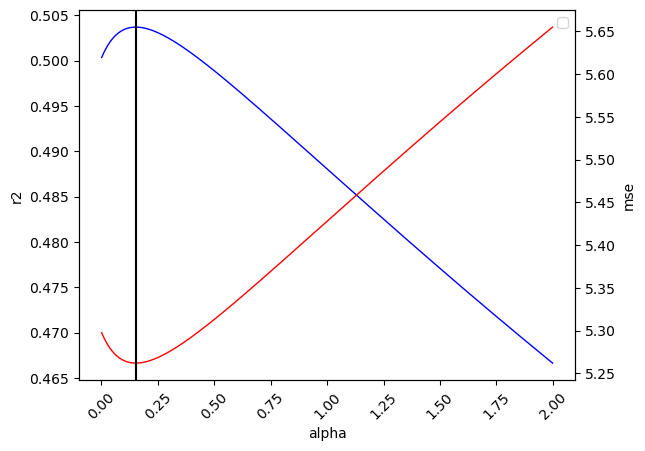

In [719]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

ax1.plot(lambda_list,r2,color="blue",linewidth=1 )
ax1.set_xlabel("alpha")
ax1.set_ylabel("r2")

ax2 = ax1.twinx()
ax2.plot(lambda_list,mse,color="red",linewidth=1 )
ax2.set_ylabel("mse")

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.axvline(lambda_best, c='black')

plt.show()

### test parameter

In [720]:
# lambda_ = np.exp(-3)
lambda_ = lambda_list[r2.index(max(r2))]
lambda_

0.152

In [721]:
ridge_tunning = Ridge(alpha=lambda_) 
ridge_tunning.fit(df_train_clean.iloc[:,:-1],df_train_clean.iloc[:,-1])

Ridge(alpha=0.152)

In [722]:
print("MSE:",metrics.mean_squared_error(y_test, ridge_tunning.predict(x_test)))
print("R_2:",r2_score(y_test, ridge_tunning.predict(x_test)))

MSE: 5.262026439803864
R_2: 0.5036911481604605


In [723]:
# before tunning
print("MSE:",metrics.mean_squared_error(y_test, ridge_predict))
print("R_2:",r2_score(y_test, ridge_predict))

MSE: 5.2921725299157405
R_2: 0.5008478003472111


In [724]:
ridge_tunning.coef_
ridge_tunning.intercept_

array([ 10.11461649, -15.4154572 ,   6.47902241,  -8.46783723,
        10.28434711,   8.27060269,   0.75258258,   0.82867463])

3.479945468793664

In [725]:
ridge_summary(ridge_tunning,df_train_clean.iloc[:,:-1],df_train_clean.iloc[:,-1]).summary()

Residuals:
   Min     1Q  Median      3Q  Max
4.9876 7.9808  9.2804 10.5215 16.0


Coefficients:
                 Estimate  Std. Error  t value   p value
_intercept       3.479945    0.103734  33.5468  0.000000
Shell_Weight    10.114616    1.303912   7.7571  0.000000
Shucked_Weight -15.415457    0.833062 -18.5046  0.000000
Whole_Weight     6.479022    0.541248  11.9705  0.000000
Viscera_Weight  -8.467837    1.330170  -6.3660  0.000000
Height          10.284347    2.160128   4.7610  0.000002
Diameter         8.270603    0.900612   9.1833  0.000000
Sex_F            0.752583    0.079136   9.5100  0.000000
Sex_M            0.828675    0.071629  11.5690  0.000000
---
R-squared:  0.65439,    Adjusted R-squared:  0.65316
F-statistic: 532.05 on 8 features


# 7. Test test-set

In [726]:
def score(predict_data):
    
    print("MSE:",metrics.mean_squared_error(data_test.iloc[:,-1], predict_data))
    print("R_2:",r2_score(data_test.iloc[:,-1], predict_data))

### Linear Regression

In [727]:
lr.coef_
lr.intercept_

array([[  7.99362175, -19.44029822,   9.08612213, -11.22026898,
         14.42839055,   9.53597341,   0.76711329,   0.84622189]])

array([3.03592641])

In [728]:
lr_predict = lr.predict(data_test.iloc[:,:-1])

In [729]:
score(lr_predict)

MSE: 4.936067703850602
R_2: 0.5443276994678137


### Ridge Regression - alpha=0.1

In [730]:
rr.coef_
rr.intercept_

array([[  8.04780282, -19.39245154,   9.04280029, -11.13388794,
         14.25690699,   9.53735124,   0.76837306,   0.84726946]])

array([3.04860215])

In [731]:
rr_predict = rr.predict(data_test.iloc[:,:-1])

In [732]:
score(rr_predict)

MSE: 4.937792795232039
R_2: 0.5441684479328733


### Ridge Regression - alpha=lambda after tunning

In [733]:
ridge_tunning.coef_
ridge_tunning.intercept_

array([ 10.11461649, -15.4154572 ,   6.47902241,  -8.46783723,
        10.28434711,   8.27060269,   0.75258258,   0.82867463])

3.479945468793664

In [734]:
ridge_predict = ridge_tunning.predict(data_test.iloc[:,:-1])

In [735]:
score(ridge_predict)

MSE: 5.214464213668421
R_2: 0.5186275701948995


# 8. Analysis Result - Ridge Regression - alpha=lambda after tunning

In [736]:
list(ridge_predict)

[12.415125817426997,
 8.736229244021583,
 9.92746950361412,
 5.532586679278792,
 10.28652996878913,
 11.455283168668768,
 8.023553946585409,
 9.581050230041988,
 7.864255064368351,
 11.58088324196249,
 7.919971897878918,
 6.195024014473978,
 8.170924150318541,
 8.958057395688447,
 5.743774261448018,
 9.236630957278571,
 8.046709506562632,
 12.989926480156702,
 10.717218636555828,
 7.518438876411253,
 7.240718845539757,
 6.731603773055174,
 8.490374546589809,
 7.7268536949662465,
 9.162775099161687,
 10.972211158695188,
 5.567125950109218,
 12.44014165201934,
 9.58552346597134,
 10.99745237302891,
 8.138045758746191,
 4.691579023674937,
 10.8388457150714,
 12.389060168397906,
 7.007062331605557,
 8.456192844055977,
 8.280856033800504,
 9.91322552464685,
 7.933953506472246,
 11.26327967641299,
 11.047258648399104,
 9.195895358233269,
 11.388516322976322,
 11.213700322059323,
 11.774438821666985,
 9.35078836607748,
 8.992509071982795,
 11.530788856469348,
 10.967813195671031,
 7.640012985

In [737]:
result = pd.DataFrame([list(ridge_predict),data_test.iloc[:,-1].tolist()]).T.rename(columns={0: "predict", 1: "Rings"})


In [738]:
result['abs_diff'] = abs(result['predict']-result['Rings'])

In [739]:
result['abs_diff'].mean()

1.556218814984822

In [740]:
df['Rings'].describe()

count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Rings, dtype: float64

In [741]:
result['abs_diff'].describe()

count    835.000000
mean       1.556219
std        1.672123
min        0.002293
25%        0.473185
50%        1.054583
75%        2.029511
max       15.109304
Name: abs_diff, dtype: float64

In [742]:
result[result['abs_diff']<2].shape[0]/result.shape[0]

0.7449101796407186

In [743]:
result[result['abs_diff']<1].shape[0]/result.shape[0]

0.4718562874251497

# 9. Other advanced methods to predict

## 9.1 GBDT

In [744]:
df_train_clean.head()

,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings
649,0.140,0.1695,0.4470,0.0810,0.125,0.360,1.0,0.0,9
2190,0.315,0.3215,0.9270,0.1985,0.165,0.470,0.0,1.0,11
2991,0.276,0.5305,1.0835,0.2310,0.150,0.485,0.0,1.0,8
2768,0.251,0.3290,0.7200,0.1030,0.135,0.435,0.0,0.0,11
2454,0.027,0.0385,0.0920,0.0235,0.065,0.200,0.0,0.0,5


In [745]:
from sklearn import ensemble
gbr = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=4)
gbdt_model = gbr.fit(df_train_clean.iloc[:,:-1],df_train_clean.iloc[:,-1])
gbdt_predict = gbdt_model.predict(data_test.iloc[:,:-1])
gbdt_result = pd.DataFrame([list(gbdt_predict),data_test.iloc[:,-1].tolist()]).T.rename(columns={0: "predict", 1: "Rings"})
gbdt_result['abs_diff'] = abs(gbdt_result['predict']-gbdt_result['Rings'])

In [746]:
gbdt_result['abs_diff'].mean()

1.5123434898338408

In [747]:
gbdt_result[gbdt_result['abs_diff']<2].shape[0]/gbdt_result.shape[0]
gbdt_result[gbdt_result['abs_diff']<1].shape[0]/gbdt_result.shape[0]

0.7652694610778443

0.48862275449101794

## 9.2 RF

In [748]:
rfr = ensemble.RandomForestRegressor(n_estimators=500, max_depth=5)
rf_model = rfr.fit(df_train_clean.iloc[:,:-1],df_train_clean.iloc[:,-1])
rf_predict = rf_model.predict(data_test.iloc[:,:-1])

rf_result = pd.DataFrame([list(rf_predict),data_test.iloc[:,-1].tolist()]).T.rename(columns={0: "predict", 1: "Rings"})
rf_result['abs_diff'] = abs(rf_result['predict']-rf_result['Rings'])

In [749]:
rf_result['abs_diff'].mean()

1.549289451467679

In [750]:
rf_result[rf_result['abs_diff']<2].shape[0]/rf_result.shape[0]
rf_result[rf_result['abs_diff']<1].shape[0]/rf_result.shape[0]

0.7580838323353294

0.481437125748503

## 9.3 AdaBoost

In [751]:
adr = ensemble.AdaBoostRegressor(n_estimators=50)
ad_model = adr.fit(df_train_clean.iloc[:,:-1],df_train_clean.iloc[:,-1])
ad_predict = ad_model.predict(data_test.iloc[:,:-1])

ad_result = pd.DataFrame([list(ad_predict),data_test.iloc[:,-1].tolist()]).T.rename(columns={0: "predict", 1: "Rings"})
ad_result['abs_diff'] = abs(ad_result['predict']-ad_result['Rings'])

In [752]:
ad_result['abs_diff'].mean()

1.6214281936545265

In [753]:
ad_result[ad_result['abs_diff']<2].shape[0]/ad_result.shape[0]
ad_result[ad_result['abs_diff']<1].shape[0]/ad_result.shape[0]

0.7245508982035929

0.41077844311377243

## 9.4 XGBoost

In [754]:
import xgboost
xgbr = xgboost.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=200)
xgb_model = xgbr.fit(df_train_clean.iloc[:,:-1],df_train_clean.iloc[:,-1])
xgb_predict = xgb_model.predict(data_test.iloc[:,:-1])

xgb_result = pd.DataFrame([list(xgb_predict),data_test.iloc[:,-1].tolist()]).T.rename(columns={0: "predict", 1: "Rings"})
xgb_result['abs_diff'] = abs(xgb_result['predict']-xgb_result['Rings'])

In [755]:
xgb_result['abs_diff'].mean()

1.5196170207269177

In [763]:
xgb_result[xgb_result['abs_diff']<2].shape[0]/xgb_result.shape[0]
xgb_result[xgb_result['abs_diff']<1].shape[0]/xgb_result.shape[0]

0.7664670658682635

0.48383233532934133

# 10. Adjust independent variable

In [757]:
df_train_clean['shell_proportion'] = df_train_clean['Shell_Weight']/ df_train_clean['Whole_Weight']
df_train_clean['edible_proportion'] = (df_train_clean['Viscera_Weight'] + df_train_clean['Shucked_Weight'])/df_train_clean['Whole_Weight']
df_train_clean.head()

,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings,shell_proportion,edible_proportion
649,0.140,0.1695,0.4470,0.0810,0.125,0.360,1.0,0.0,9,0.313199,0.560403
2190,0.315,0.3215,0.9270,0.1985,0.165,0.470,0.0,1.0,11,0.339806,0.560949
2991,0.276,0.5305,1.0835,0.2310,0.150,0.485,0.0,1.0,8,0.254730,0.702815
2768,0.251,0.3290,0.7200,0.1030,0.135,0.435,0.0,0.0,11,0.348611,0.600000
2454,0.027,0.0385,0.0920,0.0235,0.065,0.200,0.0,0.0,5,0.293478,0.673913


In [758]:
data_test['shell_proportion'] = data_test['Shell_Weight']/ data_test['Whole_Weight']
data_test['edible_proportion'] = (data_test['Viscera_Weight'] + data_test['Shucked_Weight'])/data_test['Whole_Weight']
data_test.head()

,Shell_Weight,Shucked_Weight,Whole_Weight,Viscera_Weight,Height,Diameter,Sex_F,Sex_M,Rings,shell_proportion,edible_proportion
668,0.3350,0.2775,0.9175,0.2430,0.155,0.425,0.0,1.0,13,0.365123,0.567302
1580,0.1935,0.2610,0.6160,0.1430,0.120,0.400,0.0,0.0,8,0.314123,0.655844
3784,0.3175,0.5270,1.2555,0.3740,0.155,0.480,0.0,1.0,11,0.252887,0.717642
463,0.0200,0.0215,0.0545,0.0120,0.055,0.165,0.0,0.0,5,0.366972,0.614679
2615,0.3775,0.6735,1.5105,0.3755,0.175,0.500,0.0,1.0,12,0.249917,0.694472


In [759]:
lm_reg_new = ols('Rings ~ shell_proportion + edible_proportion + Height + Diameter + Sex_F + Sex_M', data = df_train_clean).fit()
lm_reg_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Rings   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     655.3
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:58:00   Log-Likelihood:                -3938.9
No. Observations:                2257   AIC:                             7892.
Df Residuals:                    2250   BIC:                             7932.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.9522      0.745      9.326      0.000       5.490       8.414
shell_proportion      9.3207      1.022      9.120      0.000       7.317      11.325
edible_proportion   -11.0747      0.766    -14.460      0.000     -12.577      -9.573
Height               16.3367      2.077      7.866      0.000      12.264      20.410
Diameter             10.3174      0.787     13.102      0.000       8.773      11.862
Sex_F                 0.7472      0.089      8.379      0.000       0.572       0.922
Sex_M                 0.7496      0.082      9.187      0.000       0.590       0.910
==============================================================================
Omnibus:                       81.921   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.377
Skew:                           0.490   Prob(JB):                     2.37e-20
Kurtosis:                       3.040   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [760]:
lm_new_predict = lm_reg_new.predict(data_test)
lm_new_result = pd.DataFrame([list(lm_new_predict),data_test.iloc[:,-3].tolist()]).T.rename(columns={0: "predict", 1: "Rings"})
lm_new_result['abs_diff'] = abs(lm_new_result['predict']-lm_new_result['Rings'])

In [761]:
lm_new_result['abs_diff'].mean()

1.648474602821079

In [764]:
lm_new_result[lm_new_result['abs_diff']<2].shape[0]/lm_new_result.shape[0]
lm_new_result[lm_new_result['abs_diff']<1].shape[0]/lm_new_result.shape[0]

0.7520958083832335

0.45149700598802395